# Tema: Classificação e Regressão via um MLP




Importar bibliotecas necessárias

In [ ]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import operator
%matplotlib inline
import cv2
import PIL
from IPython.display import display

def cv2_imshow(a):
  """A replacement for cv2.imshow() for use in Jupyter notebooks."""
  a = a.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


print(tf.__version__)



1.15.0-rc3


## MLP

O perceptron multicamadas (MLP) é uma rede neural semelhante ao perceptron simples, porém possui mais de uma camada de neurônios. Em casos em que não há a possibilidade de uma única reta separar os elementos, pode-se fazer uso do MLP, o qual gera mais de uma reta classificadora.

Um MLP tem a seguinte estrutura básica:
* Uma camada de neurônios de entrada, que não é composta necessariamente de neurônios.
* Uma ou mais camadas intermediárias (ocultas) de neurônios interligados, formando a estrutura central de processamento da rede neural.
* Uma camada de neurônios de saída, conectada aos neurônios da ultima camada oculta, gerando a resposta final da RNA.

Cabe indicar que:
* Diferentes camadas podem aplicar diferentes funções de ativação em suas entradas.
* O sentido do fluxo de informação é da primeira (entrada), para a última camada (saída).

A seguinte figura apresenta a estrutura básica de um MLP, a qual possui:
* Uma camada de entrada ( dois valores de entrada).
* Duas camadas ocultas, a primeira com três neurônios e a segunda com dois neurônios, com funções de ativação $f_1$ e $f_2$ respectivamente.
* Uma camada de saída com um único neurônio e função de ativação $f_3$.

<center>
<img src='https://drive.google.com/uc?id=1k-6scX3FImgv9bt9zpiiT3NJE8a_Me-a' width=50%>
</center>

O aprendizado nesse tipo de rede é geralmente feito através do **algoritmo de retropropagação do erro**, mas existem outros algoritmos para este fim.

O termo "perceptron multicamadas" muitas vezes causa confusão. Argumenta-se que o modelo não é o único perceptron que tem várias camadas. Em vez disso, ele contém muitos perceptrons que são organizados em camadas, levando alguns a acreditar que um termo mais adequado poderia, portanto, ser "rede perceptron multicamadas". Além disso, esses "perceptrons" não são realmente perceptrons em sentido  estrito. Verdadeiros perceptrons são um caso especial de neurônios artificiais que usam uma função de ativação binária, ao passo que os neurônios artificiais em um perceptron multicamadas são livres para assumir qualquer função de ativação arbitrária. **Consequentemente, ao passo que um verdadeiro perceptron executa classificação binária, um neurônio em um perceptron multicamadas é livre para efetuar classificação ou regressão, dependendo de sua função de ativação.**

Os dois argumentos apresentados acima podem ser conciliados com o nome de "perceptron multicamadas" se "perceptron" for simplesmente interpretado como significando um classificador binário, independente da aplicação mecanicista específica de um perceptron clássico. Neste caso, a totalidade da rede pode, efetivamente, ser considerada como um classificador binário com múltiplas camadas. Além disso, o termo "perceptron multicamadas" agora não especifica a natureza das camadas; as camadas são livres para compor-se de neurônios artificiais gerais e não especificamente perceptrons. Esta interpretação do termo "perceptron multicamadas" evita o afrouxamento da definição de "perceptron" para significar um neurônio artificial em geral.


>>**Um pouco de história**. Minsky e Papert analisaram matematicamente o Perceptron e demostraram que redes de uma camada não são capazes de solucionar problemas que não sejam linearmente separáveis. Como não acreditavam na possibilidade de se construir um método de treinamento para redes com mais de uma camada, eles concluíram que as redes neurais seriam sempre suscetíveis a essa limitação.

>>Contudo, o desenvolvimento do algoritmo de treinamento backpropagation, por Rumelhart, Hinton e Williams em 1986, precedido por propostas semelhantes ocorridas nos anos 70 e 80, mostrou que é possível treinar eficientemente redes com camadas intermediárias, resultando no modelo de Redes Neurais MLP, treinadas com o algoritmo backpropagation.

## Anatomia de uma rede neural em Keras

O treinamento de uma rede neural gira em torno dos seguintes objetos:
* **_Layers_ (Camadas)**, que são combinadas em uma rede (ou modelo)
* **Dados de entrada** (**_examples_**)  e as correspondentes **saidas esperadas** (**_targets_**) .
* **_Loss function_ (função de perda)**, que define o sinal de _feedback_ a ser usado para aprender.
* **_Optimizer_ (Otimizador)**, que determina como o aprendizado ocorre.

Você pode visualizar sua interação conforme ilustrado na Figura 1:
* A rede é composta por **_layers_** empilhadas, tal que, ante um **dado de entrada** a rede gera uma **previsão**.
* A **_loss function_** compara as **previsões** com os **_targets_**, produzindo um valor de perda:
   * tal valor é uma medida de quão boas são as previsões da rede em relação ao valor esperado.
* O **Optimizer** usa esse valor de perda para atualizar os pesos da rede.

**Figura 1**. Relação entre a rede, as camadas, a função de perda e otimizador.
<img src='https://drive.google.com/uc?id=1Oa8makoL5qf1QnqLV9rEPxO2mltDBkNi' width=70%>

### _Layers_: os blocos de construção do aprendizado profundo

A estrutura de dados fundamental nas redes neurais é a camada.
* Uma camada é um módulo de processamento de dados que recebe como entrada um ou mais tensores e que gera como saída um ou mais tensores.
* Algumas camadas são sem estado, mas com frequência as camadas têm um estado.
  * Aqui entendemos como estado os **pesos da camada**, que são um ou vários tensores aprendidos via o optimizador.
  * Os pesos contêm o conhecimento da rede.

Diferentes camadas são apropriadas para diferentes formatos de tensores e diferentes tipos de processamento de dados.
* Por exemplo,
  * **Dados vetoriais simples**, armazenados em **tensores bidimensionais** de tamanho `(samples, features)`, são frequentemente processados por **camadas densamente conectadas**, também chamadas como **camadas totalmente conectadas** (Classe `Dense` em Keras).
  * **Dados de sequênciais**, armazenados em **tensores 3D** de tamanho `(samples, timesteps,features)`, são normalmente processados por **camadas recorrentes**, como uma camada **LSTM**.
  * **Dados de imagem**, armazenados em **tensores 4D** de tamanho `(samples, height, width, channels)`, são geralmente processados por **camadas de convolução 2D** (Classe `Conv2D` em Keras).
  
  
Você pode pensar em camadas como os blocos LEGO de DL, uma metáfora que é explicitada por estruturas como Keras.
* A criação de modelos de DL em Keras é feita agrupando camadas compatíveis para formar _pipelines_ de transformação de dados úteis.
* A noção de **compatibilidade de camada** aqui se refere especificamente ao fato de que
  * **cada camada aceitará apenas tensores de entrada de uma certa forma e retornará os tensores de saída de uma certa forma**.

Considere o seguinte exemplo:

In [ ]:
#A dense layer with 32 output units
layer = tf.keras.layers.Dense(32, input_shape=(784,))

Estamos criando uma camada que aceitará apenas como entradas tensores 2D, onde a primeira dimensão é de $ 784 $ (o "eixo 0", a dimensão do *batch*, não é especificada e, portanto, qualquer valor seria aceito).
Essa camada retornará um tensor em que a primeira dimensão foi transformada em 32.

Assim, esta camada só pode ser conectada a uma camada que espera vetores de 32 dimensões como sua entrada.

>> **OBSERVAÇÃO**. Ao usar o Keras, você não precisa se preocupar com a compatibilidade, pois as camadas adicionadas aos seus modelos são criadas dinamicamente para corresponder à forma da camada de entrada.

Por exemplo, suponha que você escreva o seguinte:

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_shape=(784,)))
model.add(tf.keras.layers.Dense(32))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
Total params: 26,176
Trainable params: 26,176
Non-trainable params: 0
_________________________________________________________________


A segunda camada não recebeu um argumento sobre o tamanho da entrada. Em vez disso, ela inferiu automaticamente a forma de entrada como sendo a forma de saída da camada anterior.

### Modelos: redes de camadas

Um modelo de DL é um **Grafo Acíclico  Direcionado (DAG - Directed Acyclic Graph)** de camadas. A instância mais comum é uma **pilha linear de camadas**, mapeando uma única entrada para uma única saída. Mas à medida que você avança, você estará exposto a uma variedade muito maior de topologias de rede. Alguns topologias comuns são:
* *Two-branch networks*
* *Multihead networks*
* *Inception blocks*

**A topologia de uma rede define um espaço de hipótese**.
* Definimos ML como **a procura por representações úteis de alguns dados de entrada, dentro de um espaço predefinido de possibilidades, usando a orientação de um sinal de _feedback_.**
Ao escolher uma topologia de rede, você restringe seu espaço de possibilidades (espaço de hipóteses) a uma série específica de operações de tensoriais, mapeando os dados de entrada para os dados de saída.
O que você estará procurando é um bom conjunto de valores para os tensores de pesos envolvidos nessas operações de tensoriais.

### Funções de perda e otimizadores: as chaves para configurar o processo de aprendizado

Depois que a arquitetura de rede é definida, você ainda precisa escolher mais duas coisas:
* **Função de perda (_Loss function_)** - A quantidade que será minimizada durante o treinamento. Ele representa uma medida de sucesso para a tarefa em questão.
* **Otimizador (_Optimizer_)** - Determina como a rede será atualizada com base na função de perda. Ele implementa uma variante específica do gradiente estocástico de descida (SGD).

>>Uma rede neural com **várias saídas** pode ter **funções de perda múltipla (uma por saída)**. Mas o processo gradiente-descendente deve ser baseado em um único valor de perda escalar; Assim, para **redes de vários perdas (*multiloss networks*), todas as perdas são combinadas (via média) em uma única quantidade escalar**.

**Escolher a função de perda correta para o problema certo é extremamente importante**:
* sua rede tomará qualquer atalho que puder, para minimizar a funçção de perda; portanto, se a função de perda não se correlaciona totalmente com o sucesso da tarefa em questão, sua rede acabará fazendo coisas que talvez você não queira.

Imagine uma IA estúpida e onipotente treinada via SGD, com a seguinte função de perda (mal escolhida): *maximizar o bem-estar médio de todos os humanos vivos.*
* Para tornar seu trabalho mais fácil, esta IA pode escolher matar todos os humanos, exceto alguns, e se concentrar no bem-estar deles - porque o **bem-estar médio** não é afetado pela quantidade de humanos que restam.
* Isso pode não ser o que você pretendia! Apenas lembre-se de que todas as redes neurais criadas por você serão implacáveis ao diminuir sua função de perda - portanto, escolha a função de perda com sabedoria ou você terá que enfrentar efeitos colaterais indesejados.

Felizmente, quando se trata de problemas comuns, como classificação, regressão e predição de sequências, há diretrizes simples que você pode seguir para escolher a função de perda correta. Por exemplo, você usará

* **binary crossentropy** para um problema de classificação de duas classes.
* **categorical crossentropy** para um problema de classificação de muitas classes.
* **mean-squared error** para um problema de regressão.
* **connectionist  temporal classification (CTC)** para um problema de aprendizado sequencial, e assim por diante.

Somente quando você estiver trabalhando em novos problemas de pesquisa, terá que desenvolver suas próprias funções de perda.

##Problema de Classificação - Base de dados Fashion MNIST

A continuação serão descritos um conjunto de passos que permite criar um **classficador Multiclasse** baseado em um **MLP** em Keras. Os referidos passos são:
* **Passo 0. Carregando o _dataset_**.
* **Passo 1. Construindo o modelo**.
* **Passo 2. Treinando o modelo**.
* **Passo 3. Predição do modelo**.

#### Passo 0. Carregando o _dataset_

O _dataset_ [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) consiste de:
* $70.000$ imagens em tons de cinza divididas em 10 categorias.

As imagens são formadas por arrays $28 \times 28$ pixels com valores variando de $0$ a $255$ representando a escala de cinza, cada imagem mostra itens de vestuário em baixa resolução, como pode ser observado abaixo:

<center>
<img src='' width=70%>
</center>

<table>
  <tr><td>
    <img src="https://drive.google.com/uc?id=1BgJe_XIDFkzKNC1J4B9mXlfCu5QESm5w"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

<center>
  <img src='https://drive.google.com/uc?id=1-jzmEqjkMc0MaEUN4Ybdw3UAtNlDtd3P' width=70%>
</center>

>> O _dataset_Fashion Mnist é uma alternativa ao conjunto de dados [MNIST](http://yann.lecun.com/exdb/mnist/), bastante utilizado como um “Olá, mundo” para programas de ML em visão computacional. Ambos são relativamente pequenos, perfeitos para verificar se um algoritmo funciona adequadamente e servem como bons pontos de partida para testar e debugar seu código.

Para obter a _dataset_ _Fashion Mnist_ usamos o método `load()` de `tensorflow_datasets` o qual retorna dois objetos `dataset` e `metadata`:
* `dataset`: é um objeto que representa o _dataset_ _Fashion Mnist_.
* `metadata`: é um objeto que contem a informação do _dataset_ _Fashion Mnist_.

Apartir do objeto `dataset` são obtidos os conjuntos de treino e teste, tal que:
* `train_dataset` é o conjunto separados para treino.
* `test_dataset é o conjunto separados para teste.

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.


A seguinte função denominada `informationFashionMNIST` usando o objeto `metadata`, retornado por `tdfs.load`, gera como saídas:
* o número de pixels de cada imagem,
* o número de pares de treino,
* o número de pares de teste e
* o número de classes do _Fashion Mnist_.

Podemos ver que:
* 60.000 imagens são utilizadas para treino.
* 10.000 imagens são utilizadas para teste.


In [ ]:
def informationFashionMNIST(metadata):
  NumImageTrain = metadata.splits['train'].num_examples
  NumImageTest  = metadata.splits['test'].num_examples
  NumFeatures   = functools.reduce(operator.mul,metadata.features['image'].shape)
  NumClass      = metadata.features['label'].num_classes
  return NumFeatures,NumImageTrain,NumImageTest,NumClass

NumFeatures,NumImageTrain,NumImageTest,NumClass = informationFashionMNIST(metadata)

print('NumFeatures = %d' %(NumFeatures))
print('NumImageTrain = %d' %(NumImageTrain))
print('NumImageTest = %d' %(NumImageTest))
print('NumClass = %d' %(NumClass))

NumFeatures = 784
NumImageTrain = 60000
NumImageTest = 10000
NumClass = 10


Os rótulos (*labels*) são arrays de inteiros variando de $0$ a $9$ representando os tipos de vestuário. A tabela a seguir mostra a relação entre o rótulo e o tipo (Class) de imagem.


| Rotulo | Clase |
|---|---|
|0	|*T-shirt/top*|
|1	|*Trouser*|
|2	|*Pullover*|
|3	|*Dress*|
|4	|*Coat*|
|5	|*Sandal*|
|6	|*Shirt*|
|7	|*Sneaker*|
|8	|*Bag*|
|9	|*Ankle boot*|

Precisamos armazenar o nome das classes em um vetor para utilização posterior quando plotarmos as imagens em um gráfico, um vez que esses nomes não estão disponíveis no conjunto de dados.

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

#### Paso 1. Trabalhando com os dados

Este passo, está divivido em duas etapas:
* **Etapa 1. Normaliação das imagens**.
* **Etapa 2. Divisão do _dataset_ em treino, validação e teste**.


##### Etapa 1.1. Normaliação das imagens

O valor de cada pixel nos dados da imagem é um inteiro no intervalo `[0,255]`.

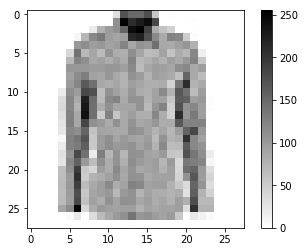

In [ ]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

O anterior implica que, os dados precisam ser preprocessados, isto é, preparados adequadamente antes de treinar o modelo. Nesse sentido, as imagens devem ser normalizadas para seus valores estar entre 0 e 1.

A normalização das imagens na escala $[0,1]$ é feito usando a função `normalize`, aplicada via uma operação de mapeamento sobre cada imagem do conjunto de treino e teste.

In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

A continuação  vamos a extrair um *batch* de imagens no Fashion Mnist, e depois, será plotado o conjunto de imagens do *batch* em um mosaico.

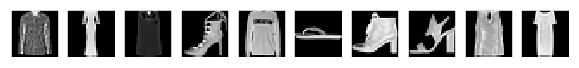

In [ ]:
image_count = 10

sns.set_style("dark")
fig, axes = plt.subplots(1, image_count, figsize=(10, 2), squeeze=False)
for index, data in enumerate(test_dataset.take(image_count)):
  image = data[0].numpy()[:,:,0]
  label = data[1].numpy()
  axes[0][index].imshow(image, cmap='gray', interpolation='nearest')
  axes[0][index].set_xticks([])
  axes[0][index].set_yticks([])

##### Etapa 1.2. Divisão do _dataset_ em treino, validação e teste

A continuação  vamos implementar a função `extractDataSet` que permite extrair, apartir do objeto `dataset`, um conjunto de pares $(imagens, labels) = (x,y)$.

In [ ]:
#implementação das funções
def extractDataSet(tt_dataset,num=60000):
  x_data = []
  y_data = []
  for index, data in enumerate(tt_dataset.take(num)):
    x_data.append(data[0].numpy()[:,:,0])
    y_data.append(data[1].numpy())
  x_data = np.asarray(x_data, dtype=np.float32)
  y_data = np.asarray(y_data, dtype=np.float32)
  #print ('x_data Examples Loaded = ' + str(x_data.shape))
  #print ('y_data Examples Loaded = ' + str(y_data.shape))
  #print('')
  return x_data, y_data

Testamos a função `extractDataSet` extraindo $100$ pares, tanto do _datasets_ de treino como de teste, e plotamos as imagens em um mosaico $10 \times 10$.

--------------------------------------------------
[[3. 9. 7. 6. 3. 2. 4. 9. 6. 7.]
 [2. 2. 7. 2. 0. 7. 9. 8. 8. 3.]
 [3. 9. 4. 3. 1. 3. 6. 9. 5. 3.]
 [9. 7. 5. 9. 0. 1. 7. 3. 9. 1.]
 [5. 8. 9. 4. 0. 2. 2. 5. 4. 5.]
 [5. 5. 2. 0. 0. 6. 7. 9. 9. 6.]
 [0. 7. 1. 0. 5. 5. 8. 2. 5. 9.]
 [0. 4. 3. 9. 5. 0. 6. 1. 4. 5.]
 [9. 0. 7. 4. 1. 3. 5. 5. 4. 4.]
 [5. 4. 5. 2. 9. 5. 6. 5. 2. 5.]]


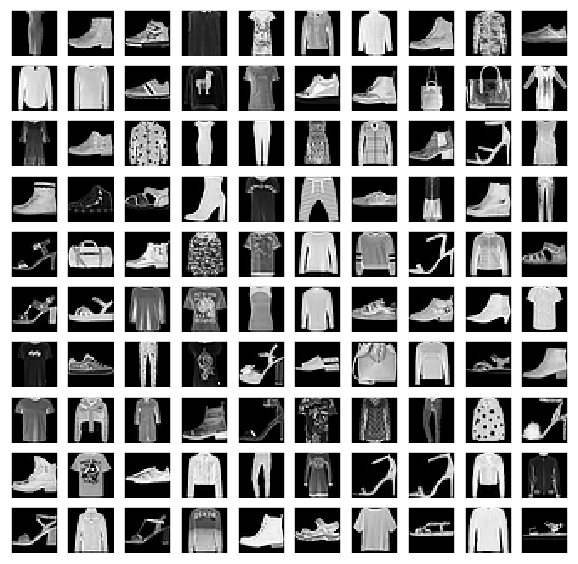

In [ ]:
#teste
Ncount = 100
x_train_subset, y_train_subset = extractDataSet(train_dataset,Ncount)
x_test_subset, y_test_subset = extractDataSet(test_dataset,Ncount)

print ('--------------------------------------------------')
print(y_train_subset.reshape(10,10))

# Set the aesthetic style of the plots
sns.set_style("dark")

# Create image_count subplots
fig, axes = plt.subplots(10, 10, figsize=(10, 10), squeeze=False)

for i in range(10):
  for j in range(10):
    image = x_train_subset[i+10*j].reshape(28,28)
    axes[j][i].imshow(image, cmap='gray', interpolation='nearest')
    axes[j][i].set_xticks([])
    axes[j][i].set_yticks([])

Agora vamos a implementar a função `splitTrain` que permita dividir um conjunto de pares $(x,y)$ em duas partes.

In [ ]:
from sklearn.model_selection import train_test_split

def splitTrain(train_images, train_labels, test_size=0.5):
  train1_images, train2_images, train1_labels, train2_labels = train_test_split(train_images, train_labels, test_size=1.0 - test_size, shuffle=True)
  return (train1_images, train1_labels), (train2_images, train2_labels)

Como foi comentado em aula, para o problema de classificação é recomendável usar a codificação **_One Hot encoding_**. Nesse sentido, a seguinte função denomidada `dense_to_one_hot` determina o *one hot encoding* de cada *label* do Fashion MNIST.

In [ ]:
def dense_to_one_hot( labels_dense, num_classes=10):
  labels_one_hot = np.eye(num_classes)[np.int32(labels_dense)]
  return labels_one_hot

Então:
* Usando a função `extractDataSet` convertimos em conjuntos de pares $(imagens, labels) = (x,y)$ os objetos que representam  os _datasets_ de treino e teste do _Fashion MNIST_.
* Usando a função `splitTrain` dividimos cojunto de treino em dois sub-conjuntos de proporções $90\%$ e $10\%$. Onde $90\%$ é o novo conjunto de treino e $10\%$ é o conjunto de validação.
* Finalmente, usando a função `dense_to_one_hot` já desenvolvida determinamos o *one hot encoding* dos rotulos $y$ para os conjuntos de treino validação e teste.

In [ ]:
NumClass = 10

x_treino, y_treino = extractDataSet(train_dataset,NumImageTrain)
x_test, y_test     = extractDataSet(test_dataset,NumImageTest)

(x_train, y_train), (x_valid, y_valid) = splitTrain(x_treino, y_treino,0.9)
y_train_one_hot = dense_to_one_hot(y_train,NumClass)
y_valid_one_hot = dense_to_one_hot(y_valid,NumClass)
y_test_one_hot  = dense_to_one_hot(y_test,NumClass)

NumImageTrainTotal  = x_treino.shape[0]
NumImageTrain       = x_train.shape[0]
NumImageValid       = x_valid.shape[0]
NumImageTest        = x_test.shape[0]

#print(y_train_one_hot[0:9])
#print(y_test_one_hot[0:9,:])

print('NumImageTrain = %d (%2.1f%s do treino)' %(NumImageTrain,100*NumImageTrain/NumImageTrainTotal,'%'))
print('NumImageValid = %d (%2.1f%s do treino)' %(NumImageValid,100*NumImageValid/NumImageTrainTotal,'%'))
print('NumImageTest  = %d (%2.1f%s do total)' %(NumImageTest,100*NumImageTest/(NumImageTest+NumImageTrainTotal),'%'))

NumImageTrain = 54000 (90.0% do treino)
NumImageValid = 6000 (10.0% do treino)
NumImageTest  = 10000 (14.3% do total)


#### Passo 2.  Construindo o modelo

Construir um MLP requer a configuração das camadas do modelo e a compilação do modelo. Assm, este passo, está divivido em duas etapas:
* **Etapa 1. Configuração das camadas**.
* **Etapa 2. Compilação do modelo**.



##### Etapa 1.1.  Configuração das camadas

O bloco de construção básico de uma modelo em Keras é a *camada*.
* Uma camada extrai uma representação dos dados inseridos nela. Esperançosamente, uma série de camadas conectadas resulta em uma representação que é significativa para o problema em questão.

Muito do aprendizado profundo consiste em encadear camadas simples. A maioria das camadas, como `tf.keras.layers.Dense`, possui parâmetros internos que são ajustados (" aprendidos ") durante o treinamento.

Para o caso de um MLP é necessario usar um modelo com um camada de entrada, uma  ou varias camadas ocultas e uma camada de saída. Para o caso do seguinte exemplo, será construida um MLP de três camadas:

* **camada de entrada** `tf.keras.layers.Flatten` - Esta camada transforma a imagen de entrada (um array 2D de $28\times28$ pixels), para um array 1D (de 784 (=$28*28$) pixels ). Esta camada não tem parâmetros para aprender, pois só reformata os dados de entrada.

* **camada oculta** `tf.keras.layers.Dense`— Uma camada densamente conectada de $128$ neurônios (ou nós). Cada neurônio tem a função `relu` como função de ativação e pesos que serão aprendidos durante o treinamento.  

* **camada de saída** `tf.keras.layers.Dense` - Uma camada de 10 nós com cada nó representando uma tipo de roupa. Cada neurônio tem a função `sofmax` como função de ativação e pesos que serão aprendidos durante o treinamento.
A saída gerada por cada nó desta camada é um valor que esta na faixa de $[0, 1]$, representando a probabilidade de a imagem de entrada pertencer a uma determinada classe.




In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


##### Etapa 2.2.  Compilação do modelo

Antes do modelo estar pronto para o treinamento, ele precisa de mais algumas configurações. Estes são adicionados durante a etapa de compilação do modelo:

* **Função de perda (Loss Function)** - Uma função para medir o quão longe as previsões estão do resultado desejado. (A diferença medida é chamada de perda (loss)).
  * No exemplo a seguir é usada a função de perda: `categorical_crossentropy`.
* **Otimizador** - Uma implementação específica do algoritmo de gradiente descendente.
  * No exemplo a seguir é usado a versão do SGD: `adam`.
* **Métricas** - usadas para monitorar as etapas de treinamento e teste.
  * No exemplo a seguir é usada a métrica: `accuracy`.



In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Passo 3. Treinando o modelo

O treinamento é realizado chamando o método `model.fit`:
1. **Objetivo**. o modelo aprenderá a associar $x$ e $y$.
1. Alimente os dados de treinamento para o modelo usando o conjunto de dados: `(x_train, y_train_one_hot)`.
1. Alimente os dados de validação para o modelo usando o conjunto de dados: `(x_valid, y_valid_one_hot)`.
1. Treinamos o modelo aplicando uma operação de shuffling sobre os dados de treino (`shuffle=True`) a cada epoca, considerando
  * `NUM_EPOCHS=100` épocas (100 iterações sobre todo o conjunto completo dos dados de treinamento), em mini-lotes de `BATCH_SIZE =32` amostras.
  * Ao mesmo tempo, são calculadas a `loss` e `accuracy` nas amostras do conjunto de validação.


Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 8s 157us/sample - loss: 0.5068 - acc: 0.8227 - val_loss: 0.4224 - val_acc: 0.8498
Epoch 2/10
54000/54000 [==============================] - 7s 133us/sample - loss: 0.3788 - acc: 0.8638 - val_loss: 0.3877 - val_acc: 0.8580
Epoch 3/10
54000/54000 [==============================] - 7s 131us/sample - loss: 0.3415 - acc: 0.8759 - val_loss: 0.3667 - val_acc: 0.8632
Epoch 4/10
54000/54000 [==============================] - 7s 129us/sample - loss: 0.3153 - acc: 0.8847 - val_loss: 0.3383 - val_acc: 0.8767
Epoch 5/10
54000/54000 [==============================] - 7s 128us/sample - loss: 0.2969 - acc: 0.8901 - val_loss: 0.3371 - val_acc: 0.8810
Epoch 6/10
54000/54000 [==============================] - 7s 130us/sample - loss: 0.2818 - acc: 0.8958 - val_loss: 0.3317 - val_acc: 0.8807
Epoch 7/10
54000/54000 [==============================] - 7s 128us/sample - loss: 0.2734 - acc: 0.8997 - val_lo

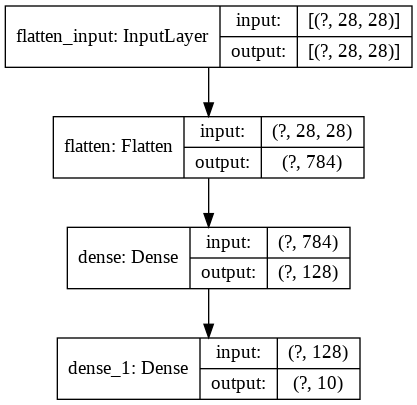

In [ ]:
BATCH_SIZE = 32 # number de amostras por batch
NUM_EPOCHS = 10 # numero de epocas

history = model.fit(x_train, y_train_one_hot, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS,verbose=1, validation_data=(x_valid, y_valid_one_hot))

model.summary()

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

image = cv2.imread("model_plot.png")
cv2_imshow(image)

Algumas observações:
* Na CPU, isso levará menos de 2 segundos por época - o treinamento termina em 200 segundos.
* No final de cada época, há uma pequena pausa enquanto o modelo calcula sua `loss` e `accuracy` nas amostras do conjunto de validação.




Note que a chamada  de `model.fit()` retorna um objeto `History`. Este objeto tem um membro `history`, que é um dicionário que contém os dados sobre tudo o que aconteceu durante o treinamento. Vamos ver:

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


O dicionário contém quatro entradas: uma por métrica que estava sendo monitorada durante o treinamento e durante a validação. Nas duas listas celulas de código, vamos usar o Matplotlib para:
1. plotar o valor da `loss` para os conjuntos de treinamento e validação lado a lado (veja a Lista A),
1. plotar o valor da `accuracy` para os conjuntos de treinamento e validação (veja Lista  B).


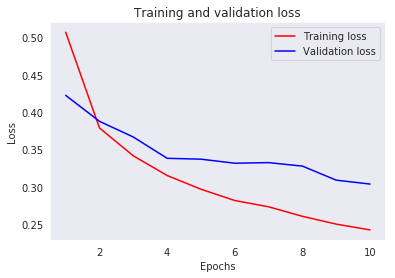

In [ ]:
#Listing A: Plotting the training and validation loss

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

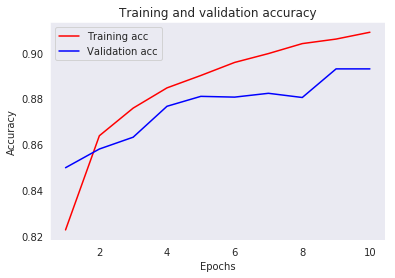

In [ ]:
#Listing B: Plotting the training and validation accuracy
plt.clf()   # clear figure
acc_values     = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Como você pode ver:
* A `loss` relacionada ao conjunto de treinamento **diminui a cada época** e
* A `accuracy` relacionada ao conjunto de treinamento **aumenta a cada época**.

Tal comportamento é o esperado ao executar a etapa de otimização usando gradiente descendente (a quantidade que você está tentando minimizar deve ser menor a cada iteração).

Também podemos calcular a  `loss` e a `accuracy` do modelo en relação ao conjunto de dados de teste usando o método `model.evaluate()`

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test_one_hot)
print('Accuracy on test dataset:', test_accuracy)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

#### Paso 4. Predição do modelo




Com o modelo treinado, podemos usá-lo para fazer previsões sobre o conjunto de teste completo ou de alguns pares $x$ e $y$

In [ ]:
y_pred_one_hot = model.predict(x_test)
print(y_pred_one_hot.shape)
print(y_pred_one_hot)

(10000, 10)
[[1.4517952e-05 7.2311432e-09 3.3429572e-03 ... 7.1680747e-12
  1.8238586e-08 7.9212409e-12]
 [7.0987476e-06 3.5872848e-03 2.5633270e-05 ... 4.1591299e-13
  1.7528896e-09 6.6483319e-11]
 [1.3755623e-01 2.1450058e-02 1.2926973e-01 ... 2.5795518e-05
  2.2258430e-03 7.1160437e-05]
 ...
 [4.5749398e-06 4.0622462e-12 4.3333458e-08 ... 1.8817524e-07
  9.9999344e-01 4.7976120e-11]
 [1.2909839e-02 8.8952510e-07 1.9720948e-01 ... 5.0117825e-13
  1.2595761e-05 2.4819977e-12]
 [9.9999976e-01 1.1924068e-11 3.5141621e-08 ... 1.0554103e-27
  2.0375643e-12 3.3720066e-21]]


Aqui, o modelo previu o saída em *one hot encoding* para cada entrada do conjunto de teste.
* As previsões é uma matriz com 10 colunas. Estes descrevem a "confiança" do modelo que a imagem corresponde a cada um das 10 possiveis classes.

Usando a função `argmax` de numpy determinamos o rotulo que tem a maior valor de confiança para cada entrada:

In [ ]:
y_pred = np.argmax(y_pred_one_hot,1)
print(y_pred)

[6 3 6 ... 8 4 0]


E podemos calcular a matriz de confusão entre os rotulos preditos `y_pred` e os rótulos de testes `y_test`.



In [ ]:
from sklearn.metrics import confusion_matrix

def matConfusion(y_test, y_pred):
  matConf = confusion_matrix(y_test, y_pred)
  acc = np.trace(matConf)/np.sum(matConf)
  terr  = 1 - acc
  return matConf,terr,acc

matConf,terr,acc = matConfusion(y_test, y_pred)

print('Matrix confusion')
print(matConf)
print('err = %f%s' %(100*terr,'%'))
print('acuracy = %f%s' %(100*acc,'%'))

Matrix confusion
[[836   0  27  19   2   2 110   0   4   0]
 [  3 970   1  19   3   0   4   0   0   0]
 [ 12   0 828   5 107   0  47   0   1   0]
 [ 22   3  17 869  49   0  36   0   4   0]
 [  0   1 102  15 839   0  42   0   1   0]
 [  0   0   0   1   0 969   0  17   0  13]
 [128   0  95  24  80   0 672   0   1   0]
 [  0   0   0   0   0  22   0 952   1  25]
 [ 12   0   9   3   6   4  10   2 954   0]
 [  0   0   0   1   0  12   1  32   0 954]]
err = 11.570000%
acuracy = 88.430000%


Podemos fazer um gráfico para ver o conjunto completo das 10 classes.

In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], int(true_labels[i]), images[i,:,:]

  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_labels):
  predictions_array, true_label = predictions_array[i], int(true_labels[i])
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Vamos utilizar essas duas funções para observar as imagens de índice 0 e 12 nos dados de teste.

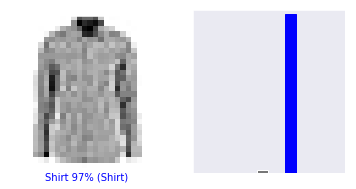

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, y_pred_one_hot, y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, y_pred_one_hot, y_test)

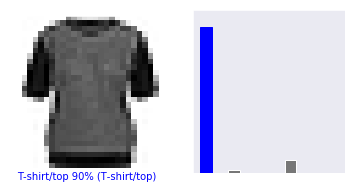

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, y_pred_one_hot, y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, y_pred_one_hot,  y_test)

Agora vamos plotar várias imagens e suas respectivas predições. Rótolos com predições corretas estão em azul e prdições incorretas estão na cor vermelha. O número dá a porcentagem (de 0 a 100) para cada classe predita.

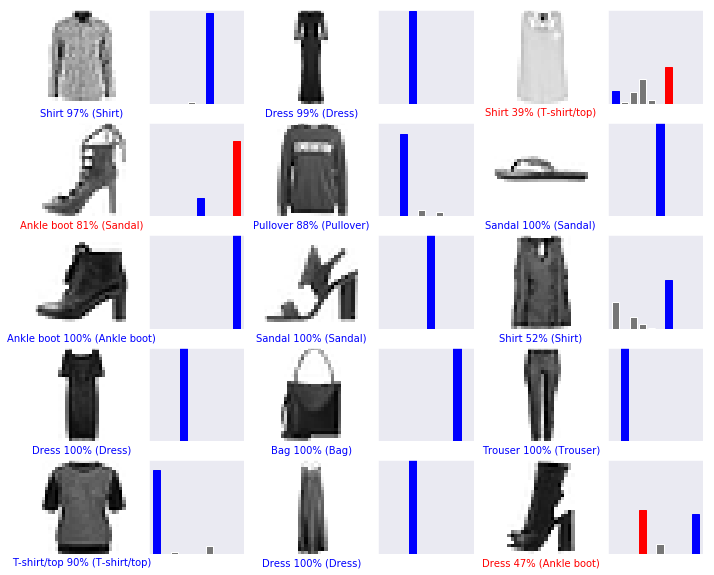

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, y_pred_one_hot, y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, y_pred_one_hot,  y_test)


Para finalizar, vamos usar nosso modelo para fazer predição de uma única imagem. Observe que, anteriormente, nós tinhamos feito a predição em todo o conjunto de teste.

In [ ]:
# Grab an image from the test dataset
img = x_test[0,:,:]

print(img.shape)

(28, 28)


`tf.keras` models é otimizado para fazer predições em um **BATCH**. Então, como estamos usando uma única imagem, precisamos adicioná-la em uma lista usando o método `expand_dims` do pacote `Numpy`.

In [ ]:
# Add the image to a batch where it's the only member.
img = np.array([img])
print(img.shape)

(1, 28, 28)


Agora, fazendo a predição:

In [ ]:
predictions_single = model.predict(img)

print(predictions_single)

[[1.4517895e-05 7.2311162e-09 3.3429477e-03 5.5782009e-05 2.2168400e-02
  5.7991771e-11 9.7441840e-01 7.1680882e-12 1.8238552e-08 7.9212409e-12]]


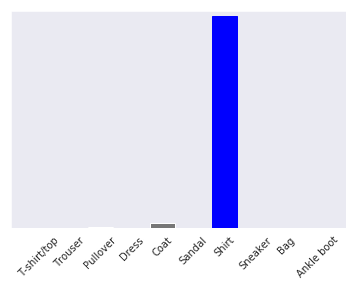

In [ ]:
plot_value_array(0, predictions_single, y_test)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:


É importante mencionar que o método `model.pridict` retorna uma lista de listas, uma para cada imagem nos Batch de dados. Então, para obter a predição para nossa única imagem é preciso indicar o índice 0, pois os arrays em python iniciam do 0.

In [ ]:
np.argmax(predictions_single[0])

6

#### Recapitulando

Aqui, você acompanhou o passo a passo de como criar e treinar sua primeira rede neural MLP usando o banco de dados Fashion MNIST. OPs tópicos que você aprendeu foram:

* Como explorar seu conjunto de dados de modo que você tenha um entendimento melhor dos dados que você tem em mãos para treinar seu modelo
* Como configurar e compilar seu modelo usando a API de alto nível Keras disponível no TensorFlow
* Como visualizar os resultados obtidos através de gráficos usando o pacote matplotlib.pyplot

##Problema de Regressão - Base de dados *Boston Housing Price*

No exemplo anterior foi considerado o problema de classificação, no qual o objetivo era determinar uma única classe referente à um dado de entrada.

Outro tipo comum de problema em ML é a regressão, que consiste em determinar um valor contínuo ao invés de uma classe específica. Por exemplo:
  * a previsão da temperatura amanhã, dado as observações meteorológicas;
  * previsão do tempo em que um software demora em ser executado, dado suas especificações.
___
**NOTA**. Não confunda **regressão** e o algoritmo de **regressão logistica (_logistic regression_)**. Pode parecer confuso, mas regressão logística e um algoritmo de classificaçãoe não um algoritmo de regressão.
___

### O banco de dados Boston Housing Price

O conjunto de dados [*Boston Housing Price*](https://www.kaggle.com/vikrishnan/boston-house-prices) foi coletado em 1978 e cada uma das 506 entradas representa dados agregados sobre 14 características de casas de vários subúrbios em Boston, Massachusetts.

Este DB possui uma diferença interessante em relação aos DB já estudados. Ele apresenta relativamente poucos dados :
  * Somente 506 amostras, divididas entre 404 para treino e 102 para teste.
  * Cada característisca no dado de entrada (por exemplo, a taxa de criminalidade) possui uma escala diferente.
    * Por exemplo, alguns valores variam entre 0 e 1; outros apresentam uma faixa compreendendo os valores de 1 a 12, outros de 0 a 100 e assim por diante.
  

In [ ]:
#Listing 3.24 Carregando o banco da dados 'Boston housing'


boston_housing = tf.keras.datasets.boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


Vamos observar os dados:

In [ ]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


Como vocês podem ver, temos 404 amostras para treino e 102 para teste. O dataset inclui 13 atributos, listados a seguir:

1. Taxa de criminalidade per capita.
2. Proporção de terrenos residenciais com lotes acima de 25 mil pés quadrados
3. Proporção de terras não retalhistas por cidade.
4. Charles River dummy variável (= 1 se o terreno estiver próximo ao rio; 0 caso contrário).
5. Concentração de óximo nítrico (partes por 10 milhões).
6. Número médio de quartos por habitação.
7. Proporção de habitações ocupadas, construídas antes de 1940.
8. Distância ponderada para 5 centros de emprego de Boston.
9. Índice de acessibilidade para rodovias.
10. Valor integral do imposto de propriedade dividido por $10,000.
11. Relação aluno x professor da cidade.
12. 1000 * (Bk - 0.63) ** 2 onde Bk é a proporção de negros da cidade.
13. % menor status da população.

O resultado final é o preço médio das casas habitadas , em milhares de dolares:

In [ ]:
print(train_targets)

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6
 32.2 13.1

Os preços estão geralmente entre $10,000$ e $50,000$ dólares. Se isto soa um valor barato, lembre-se que os dados se referem aos anos 70 e estes preços não estão ajustados pela inflação.

#### Paso 1. Trabalhando com os dados

Seria problemático alimentar a rede neural com estes valores com escalas tão diferentes.

A rede deve ser capaz de automaticamente se adaptar a estes dados heterogêneos, mas isto definitivamente tornaria o aprendizado mais difícil. Uma boa prática difundida para lidar com estes dados é realizar a normalização _feature-wise_.

* Para cada atributo (coluna da matriz de entrada), subtraia cada valor pela média do atributo e divida pelo seu desvio padrão, de modo que o atributo esteja centralizado em 0 e tenha um desvio padrão igual a 1. Isto pode ser realizado facilmente em `Numpy`.


Note que os valores utilizados para normalizar os dados de teste são computados usando os dados de treino.
___
**IMPORTANTE**. Você nunca deve usar em seu projeto qualquer informação computabilizada pelos dados de teste, mesmo para uma simples normalização.
___

**Exercicio**. Crie uma função denominada `normalizationFeatureWise` que efetue a normalização _feature-wise_. Exemplo:
```python
#INPUT
train_data,mean,std = normalizationFeatureWise(train_data)
test_data  -= mean
test_data  /= std
```

In [ ]:
#inserir tua solução aqui

#### Sobre a divisão do conjunto de dados e $K$-*fold cross validation*

Como foi feito nos exemplos anteriores o treinamento do modelo é realizado usando os conjuntos de treino e validação.  Porém, como tem-se poucos dados, o conjunto de validação se tornaria pequeno (em torno de 100 amostras).

Como consequência, o resultado da validação poderia mudar bastante dependendo dos dados escolhidos para os conjuntos de treino e validação. A melhor prática nestas situações é usar o **$K$-fold cross-validation** (veja Figure 11).
* Consiste em **dividir os dados disponíveis em $K$ partições iguais (geralmente $K = 4$ ou $5$)**,  instanciando $K$ modelos idênticos onde em cada um treina-se $K-1$ partições enquanto avalia-se a partição remanescente.
* O **resultado da validação** final é, portanto,  **a média dos resultados das $K$ validações obtidas**.

Em termos de código, o *$K$-fold cross-validation* pode ser implementado usando a classe `KFold` de pacote `sklearn`. Tal como é feito no exemplo a seguir:

<img src='https://drive.google.com/uc?id=1XTwfIqtK2XJ_QNpOXWlE1iTfvM1J20ya' width=100%>

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
#https://machinelearningmastery.com/k-fold-cross-validation/

from sklearn.model_selection import KFold

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])

#criamos uma instância da classe KFold, dividimos o conjunto de dados em 3 partes,
#os dados não são embaralhados antes da divisão.
kf = KFold(n_splits=2, shuffle=False)

#Chamamos ao método split(), que retorna os índices do conjunto de dados original
#a ser usadas para os conjuntos de treinamento e validação em cada partição.
for train_index, val_index in kf.split(X):
  print("TRAIN:", train_index, "VAL:", val_index)
  X_train_partial, X_val_partial = X[train_index], X[val_index]
  y_train_partial, y_val_partial = y[train_index], y[val_index]

TRAIN: [2 3] VAL: [0 1]
TRAIN: [0 1] VAL: [2 3]


**Exercicio**. Crie uma função denominada `kfoldDBHousingPrice` que efetue a $K$-fold cross-validation*, para o conjunto de treino do O banco de dados _Boston Housing Price_, considerando: $K = 10$ e sem embaralheamento dos dados antes de cada partição. A saída gerada pela função deve ser uma lista de dicionarios denominado `data_folds`. Exemplo:
```python
#INPUT
data_folds = kfoldDBHousingPrice(train_data, train_targets, n_partitions = 10)

for idx,data_fold_k in enumerate(data_folds):
    X_train_k = data_fold_k['train/X']
    y_train_k = data_fold_k['train/y']
    X_val_k   = data_fold_k['val/X']
    y_val_k   = data_fold_k['val/y']
    tup_print = (idx+1, X_train_k.shape, y_train_k.shape, X_val_k.shape, y_val_k.shape)
    print('fold %d : TRAIN(X, y) = [%s %s] VAL(X, y) = [%s %s]'%tup_print)
#OUTPUT
fold 1 : TRAIN(X, y) = [(363, 13) (363,)] VAL(X, y) = [(41, 13) (41,)]
fold 2 : TRAIN(X, y) = [(363, 13) (363,)] VAL(X, y) = [(41, 13) (41,)]
fold 3 : TRAIN(X, y) = [(363, 13) (363,)] VAL(X, y) = [(41, 13) (41,)]
fold 4 : TRAIN(X, y) = [(363, 13) (363,)] VAL(X, y) = [(41, 13) (41,)]
fold 5 : TRAIN(X, y) = [(364, 13) (364,)] VAL(X, y) = [(40, 13) (40,)]
fold 6 : TRAIN(X, y) = [(364, 13) (364,)] VAL(X, y) = [(40, 13) (40,)]
fold 7 : TRAIN(X, y) = [(364, 13) (364,)] VAL(X, y) = [(40, 13) (40,)]
fold 8 : TRAIN(X, y) = [(364, 13) (364,)] VAL(X, y) = [(40, 13) (40,)]
fold 9 : TRAIN(X, y) = [(364, 13) (364,)] VAL(X, y) = [(40, 13) (40,)]
fold 10 : TRAIN(X, y) = [(364, 13) (364,)] VAL(X, y) = [(40, 13) (40,)]
```

In [ ]:
#inserir tua solução aqui

#### Passo 2.  Construindo o modelo

Já que temos poucos exemplos disponíveis, será construida uma MLP pequena com duas camadas ocultas, cada uma com 64 unidades.

##### Passo 2.1.  Configure as camadas

A arquitetura MLP proposta esta composta por:

* ** camada de entrada ** `tf.keras.layers.Dense`— Uma camada densamente conectada de $64$ neurônios. Cada neurônio tem a função `relu` como função de ativação e pesos que serão aprendidos durante o treinamento.  

* ** "camada oculta" ** `tf.keras.layers.Dense`— Uma camada densamente conectada de $64$ neurônios. Cada neurônio tem a função `relu` como função de ativação e pesos que serão aprendidos durante o treinamento.  

* ** camada de saída ** `tf.keras.layers.Dense` - Uma camada de 1 neurônio **sem função de ativação (será uma camada com função de ativação linear)**
  * Esta é uma configuração típica para um regressão escalar (um regresssor onde se está tentando prever um simples valor contínuo). Usar outra função de ativação limitaria os valores que a saída poderia ter. Por exemplo, aplicando-se uma função de ativação `sigmoid` no neurônio de saída,  a rede aprenderia a prever somente valores entre 0 e 1.
___
**CONCLUSSÃO**.  que a ultima camada ussa funções de ativação lineares, a rede é livre para aprender a prever qualquer valor real.
___

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

##### Passo 2.2.  Compile o modelo

Aqui, é definido:

* **Função de perda (Loss Function)** - Uma função para medir o quão longe as previsões estão do resultado desejado. (A diferença medida é chamada de perda (loss)).
  * No exemplo a seguir é usada a função de perda: `mse` — erro quadrático médio (*mean squared error*). O  `mse` é o valor medio do quadrado da diferença entre os valores previstos e os valores esperados. **Esta função de perda é amplamente utilizada para problemas de regressão**.
* **Otimizador** - Uma implementação específica do algoritmo de gradiente descendente.
  * No exemplo a seguir é usado a versão do SGD: `rmsprop`.
* **Métricas** - usadas para monitorar as etapas de treinamento e teste.
  * No exemplo a seguir é usada a métrica: `mae`- erro absoluto médio (*mean absolute error*).
* O `mae`é o valor absoluto da diferença entre os valores previstos e os valores corretos. Por exemplo, um `mae = 0.5` neste problema significaria que os valores previstos estão errados, em média, $500$ dólares por amostra.


In [ ]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

**Exercicio**. Crie uma função denominada `build_model` que efetue os passo 2.1 e 2.2.
É necessario criar esta função devido ao fato de que você terá que instanciar o mesmo modelo várias vezes ao usar validação $K$-fold.

Exemplo:
```python
#INPUT
num_inputs = train_data.shape[1]
model = build_model(num_inputs)
model.summary()
#OUTPUT
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_3 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
=================================================================
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
```

In [ ]:
#inserir tua solução aqui

#### Passo 3. Treinando o modelo

O treinamento é realizado chamando o método `model.fit`:
1. **Objetivo**. o modelo aprenderá a associar $x$ e $y$.
1. Aplicamos o procedimento de treinamento baseado em $K$ ,então:
  * Dividimos o conjunto de dados em $k$ partições, usando a função `kfoldDBHousingPrice`.
  * Para cada partição:
    * instanciamos um modelo usando a funçãoi: `build_model`
    * treinamos o modelo instanciado usando o conjunto de dados: `(x_train_k, y_train_k)`.
    * validamos o modelo instanciado usando o conjunto de dados: `(x_valid_k, y_valid_k)`. A métrica de validação usada é a `mae`.
   * Calculamos a `mae` media.
    
    
Para a etapa de treinamento do modelo instanciado é considerado:
  * `NUM_EPOCHS=500` épocas (100 iterações sobre o conjunto de treinamento, em mini-lotes de `BATCH_SIZE =1` amostra.

In [ ]:
n_partition = 4
num_inputs = train_data.shape[1]
BATCH_SIZE = 1 # number de amostras por batch
NUM_EPOCHS = 100 # numero de epocas
all_scores = []

data_folds = kfoldDBHousingPrice(train_data, train_targets, n_partition)

models = []
all_mae_histories = []
for idx,data_fold_k in enumerate(data_folds):
    print('processing fold #', idx+1)
    X_train_k = data_fold_k['train/X']
    y_train_k = data_fold_k['train/y']
    X_val_k   = data_fold_k['val/X']
    y_val_k   = data_fold_k['val/y']

    # Construa o modelo feito por Keras (já compilado)
    model = build_model(num_inputs)

    # Treine o modelo (in silent mode, verbose=0)
    history = model.fit(X_train_k, y_train_k, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS,verbose = 0,validation_data=(X_val_k, y_val_k))
    models.append(model)

    mae_history = history.history['val_mean_absolute_error']

    all_mae_histories.append(mae_history)

Agora, vamos a plotar o valor do `mae` vs  `epoochs` para cada *fold* e também calcularemos o valor de `mae` medio para cada *fold* e o valor medio total.

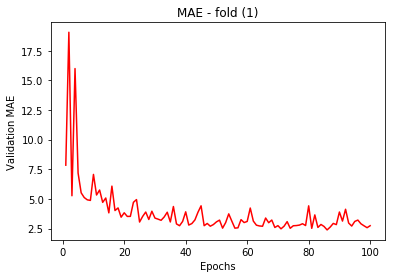

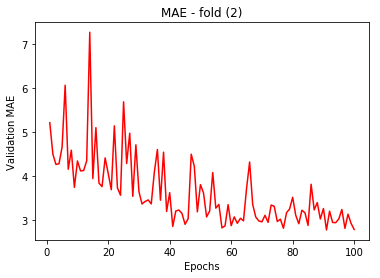

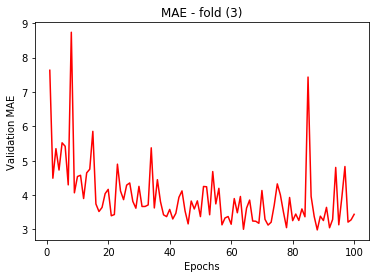

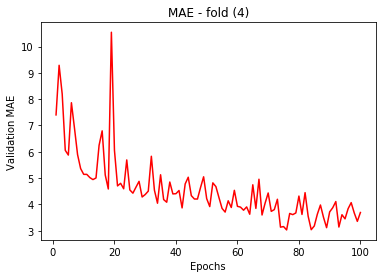

MAE mean for each fold: [3.80915, 3.6383176, 3.9588919, 4.5663333]
MAE mean: 3.9931731


In [ ]:
#Listing A: Plotting the training and validation loss

epochs = range(1, NUM_EPOCHS + 1)
all_scores = []
for idx, mae_history in enumerate(all_mae_histories):
  all_scores.append(np.mean(mae_history))
  plt.plot(epochs, mae_history, 'r', label='Training loss')
  plt.title('MAE - fold (%d)'%(idx+1))
  plt.xlabel('Epochs')
  plt.ylabel('Validation MAE')
  plt.show()

print('MAE mean for each fold: %s'%all_scores)
print('MAE mean: %s'%np.mean(all_scores))

Os experimentos mostram, de fato, diferentes resultados para a validação, variando de 2.0 a 2.6. A média dos resultados (2.49) é uma métrica mais confiável do que o valor de um dos simples resultados -- esta é a idéia da validação cruzada  $K$-fold. Neste caso, o erro está, em média, $2,490$ dólares, o que é um valor considerável visto que o preço das casas variam de $10,000$ a $50,000$ dólares.  

Para efetuar uma analise detalhado vamos a determinar a média do MAE de todas as partições, considerando cada época.

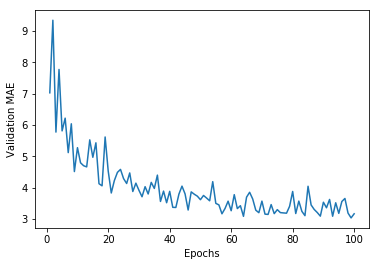

In [ ]:
average_mae_history = [ np.mean([x[i] for x in all_mae_histories]) for i in range(NUM_EPOCHS)]

plt.plot(epochs, average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Pode ser um pouco difícil observar o gráfico devido à algumas questões de escala e alta variância. Vamos então fazer as seguintes modificações:
* Omitir os 10 primeiros pontos, que estão em escala diferente em relação ao resto da curva.
* Gerar uma curva suavizada aplicando uma media movel exponencial (EMA).

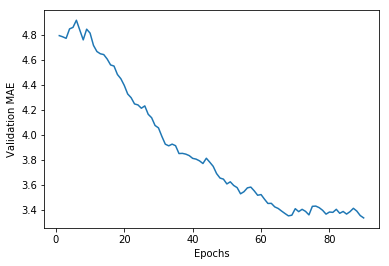

In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

De acordo com este gráfico, o valor de MAE deixa de diminuir significativamente passadas 75 épocas. Após este ponto, inicia-se o overfitting.

___
**Uma vez finalizado os ajustes de outros parâmetros do modelo (além do número de épocas, pode-se ajustar também o tamanho da camada oculta), voce deve treinar o modelo final utilizando todos os dados de treinamento, com os melhores parâmetros, e então observar a performance do modelo sobre os dados de teste.**
___

In [ ]:
num_inputs = train_data.shape[1]
BATCH_SIZE = 16 # number de amostras por batch
NUM_EPOCHS = 75 # numero de epocas estabelecido como o melhor antes iniciar o overfitting
all_scores = []

# Obtenha um novo modelo.
model = build_model(num_inputs)

# Treine o modelo com todos os dados de treinamento + validação
model.fit(train_data, train_targets,epochs=80, batch_size=BATCH_SIZE, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 977us/sample - loss: 41.5177 - mean_absolute_error: 4.5175


Aqui está o valor final:

In [ ]:
test_mae_score

4.5174613

Ainda está com um erro de $4517$ dólares por amostra.

#### Recapitulando

Aqui está o que você deve aprender deste exemplo:

* A regressão é realizada usando diferentes funções de perdas. A função de perda Erro Quadrático Médio (MSE) é comumente usada para regressão.
* Similarmente, as métricas de avaliação utilizadas para regressão **diferem das usadas para classificação; naturalmente o conceito de acurácia não é aplicado para regressão**. Uma métrica comum é **Erro Absoluto Médio (MAE)**.
* Quando atributos do dado de entrada possuem valores em escalas diferentes, cada atributo deve ser redimensionado separadamente em uma etapa de pré-processamento.
* Quando há uma pequena quantidade de dados disponíveis, o uso da validação cruzada $K$-Fold é uma boa maneira de avaliar o modelo de forma confiável.
* Quando uma pequena quantidade de dados para treinamento é disponibilizada, é preferível usar uma rede neural pequena com poucas camadas ocultas de modo a evitar o overfitting.

## _Tradeoff_ Viés-Variância

### Introdução

O dilema viés-variância é o conflito na tentativa de minimizar simultaneamente essas duas fontes de erro que impedem que os algoritmos de aprendizado supervisionados generalizem além de seu conjunto de treinamento.


Então, vamos começar com o básico e ver como eles fazem a diferença em nossos modelos de aprendizado de máquina
* **O viés** é um erro que surge de suposições errôneas no modelo de aprendizado.
  * Um **alto viés** pode fazer com que um modelo perda as relações relevantes entre as entradas e as saídas esperadas (_underfitting_).
  * Resumidamente, um modelo com alto **viés** presta pouca atenção aos dados de treinamento e simplifica demais o modelo.
* **A variância** é um erro que surge apartir da sensibilidade do modelo em relação a pequenas flutuações no conjunto de treinamento.
  * Uma **alta variância** pode fazer com que um algoritmo modele o ruído aleatório nos dados de treinamento, em vez das saídas esperadas (*overfitting*).
  * Um modelo com alta variância presta muita atenção aos dados de treinamento e não generaliza os dados que não foi visto antes.
    * Como resultado, esses modelos têm um desempenho muito bom nos dados de treinamento, mas apresentam altas taxas de erro nos dados de teste.

### Um exemplo ilustrativo: intenções de voto

Vamos realizar uma tarefa simples a construção de um modelo de votação.
* Queremos criar um modelo que determine o porcentagem de pessoas que votarão em um presidente do partido republicano na próxima eleição.

Conceitualmente, tal modelo é muito mais simples de construir do que as pessoas normalmente imaginam quando pensam em "modelagem", mas nos ajuda a ilustrar claramente a diferença entre **viés** e **variância**.

Uma maneira direta é:
* Elaboramos uma lista com $50$ números telefônicos escolhidos  aleatoriamente de uma agenda telefônica.
* Ligamos para cada um dos individuos da lista e perguntamos sobre sua inteção de voto na próxima eleição.

Suponha que obtivemos os seguintes resultados:
* Votação para o partido republicano: 13
* Votação para o partido democrata: 16
* não sabem/opinam: 21
* Total: 50

A partir dos dados, estimamos as probabilidades de votação:
* a probabilidade de um individuo votar no partido republicano é $13/(13 + 16)$, ou $44,8\%$.
* a probabilidade de um individuo votar no partido democrata é $16/(13 + 16)$, ou $55.2\%$.

Então, publicamos nosso comunicado de imprensa de que os democratas vão ganhar com mais de $10$ pontos porcentuais de diferença; mas, quando a eleição chega, acontece que eles perdem em $10$ pontos. Isso certamente reflete mal em nosso trabalho. Onde nós erramos na construção de nosso modelo?

Claramente, há muitos problemas com o modelo trivial que construímos, Por exemplo:
* Temos um tamanho de amostra muito pequeno.
* Unicamente foram considerados individuos da lista telefônica e, portanto, o modelo não considera o padrão de votação de um grupo diferentes de individuos.

É tentador agrupar todas essas causas de erro. No entanto, eles podem, na verdade, ser fontes separadas que causam viés e variância. Por exemplo:
* **Fonte de Viés**. Usar uma agenda telefônica para selecionar participantes em nossa pesquisa é uma de nossas fontes de viés. Ao pesquisar apenas certas classes de individuos, distorcemos os resultados de maneira consistente se repetirmos todo o exercício de construção do modelo.
  * **No diagrama de olho-de-boi**, a seleção sobre um conjunto restrito da poupalação alvo resulta em estimativas longes do centro do alvo, mas não resultam em uma dispersão maior das estimativas.
* **Fonte de Variância**. O pequeno tamanho do conjunto amostral é uma fonte de variância. Se aumentássemos o tamanho da amostra, os resultados seriam mais consistentes a cada vez que repetíssemos a pesquisa e a previsão.
  * Aqui, os resultados ainda podem ser altamente imprecisos devido a nossa grande fonte de **viés**, mas a variância das previsões será reduzida.
  * **No diagrama de olho-de-boi**, o baixo tamanho da amostra resulta em uma grande dispersão das estimativas. Aumentar o tamanho da amostra faria com que as estimativas seja agrupadas, mas elas ainda poderiam estar longe do centro do alvo.
  * O problema de incrementar o conjunto de dados, é que, ele deve ser fornecido antes da construção do modelo e o modelador não pode simplesmente dizer: **"Vamos aumentar o tamanho da amostra para reduzir a variância"**.
___
**Na prática, existe um tradeoff explícito entre o viés e a variância onde o decréscimo de um aumenta o outro. Minimizar o erro total do modelo requer um balanceamento cuidadoso dessas duas formas de erro.**
___


<img src='https://drive.google.com/uc?id=1mu9tKDoKkT_AWVq8Z2GFrBFb-SiJ4qIv' width=100%>



### Definição Matemática

Seja:
* $x_1,\dots, x_n$ as observações.
* $y_1,\dots, y_n$ os valores esperados associados a cada observação $x_i$

Podemos supor que existe uma relação entre $x$ com $y$ definida como:
$$
y = f(x) + \epsilon
$$

onde o termo de erro $\epsilon$ tem uma distribuição normal com média zero e variância $\sigma^2$, ou seja:
$$
\epsilon \sim N(0,\sigma^2)
$$

Queremos encontrar uma função $\hat{f}(x)$, que se aproxime à verdadeira função $f(x)$ da melhor forma possível, usando um modelo de regressão linear ou outra técnica de modelagem sofisticada como DL.
Fazemos "tão bem quanto possível" medindo o **erro quadrático médio** entre $y$ e $\hat{f}(x)$.
* Queremos que $(y - \hat{f}(x))^2 $ seja mínimo, para todo $x_1, \dots, x_n$ **como para outros pontos fora do nosso conjunto de dados**.
* É claro que não podemos esperar fazer isso com perfeição, já que o $y$ contém ruído $\varepsilon$; isso significa que devemos estar preparados para aceitar um **erro irredutível** em qualquer função que tenhamos.

Encontrar um $\hat{f}$ que seja generalizado para pontos fora do conjunto de treinamento pode ser feito com qualquer um dos inúmeros algoritmos usados para o aprendizado supervisionado. Acontece que, qualquer que seja a função $\hat{f}$ que selecionamos, podemos decompor o **valor esperado de seu erro** em uma amostra não vista pelo modelo $x$ da seguinte forma:


$$
E\Big[\big(y - \hat{f}(x)\big)^2\Big] = \operatorname{Bias}\big[\hat{f}(x)\big]^2 + \operatorname{Var}\big[\hat{f}(x)\big] + \sigma^2 \\
$$

Onde:

$$
\begin{eqnarray}
\operatorname{Bias}\big[\hat{f}(x)\big] &=& E\big[\hat{f}(x)\big] - f(x)\\
\operatorname{Var}\big[\hat{f}(x)\big] &=& E[\hat{f}(x)^2] - E[{\hat{f}}(x)]^2
\end{eqnarray}
$$

Os três termos representam:
* **o quadrado do viés do modelo**, que pode ser considerado como o erro causado pelas suposições simplificadoras propias do modelo. Por exemplo, ao se aproximar da função não linear $f(x)$ usando um modelo linear, haverá um erro nas estimativas $\hat{f}(x)$ devido a essa suposição;
* **a 'variância do modelo**, ou, intuitivamente, quanto o modelo $\hat{f}(x)$ irá mover-se na sua média;
* o **erro irredutível** $\sigma^2$. É o termo de ruído intrinseco do problema que não pode ser reduzido por nenhum modelo.

**Observações**:
* Como todos os três termos não são negativos, isso forma um limite inferior no erro esperado em amostras não vistas.
* Quanto mais complexo for o modelo $\hat{f}(x)$, mais pontos de dados serão capturados e menor será o viés.
* No entanto, a complexidade fará com que o modelo "se mova" mais para capturar os pontos de dados e, portanto, sua variância será maior.
* Supondo que contamos com o modelo real que relaciona $x$ com $y$ e temos dados infinitos para calibrá-lo, devemos ser capazes de reduzir os termos de viés e variância para $0$.  No entanto, em um mundo com modelos imperfeitos e dados finitos, sempre existirá um compromisso (_tradeoff_) entre minimizar o viés e minimizar a variância.


**A dedução da decomposição de viés-variância** para o erro quadradito medio procede da seguinte forma.
* Por conveniência de notação, abreviamos $f = f(x)$ e $\hat{f} = \hat{f}(x)$.

Primeiro, lembre-se que, por definição, para qualquer variável aleatória $x$, temos

$$
\operatorname{Var}[x] = E[x^2] - \Big(E[x]\Big)^2
$$

Reorganizando, obtemos:

$$
E[x^2] = \operatorname{Var}[x] + \Big(E[x]\Big)^2
$$


Já que:
* $f$ e um **modelo deterministico**, cumprira-se, $ E[f] = f$
* $\epsilon$, tem média zero e variância $\sigma^2$, cumprira-se, $E[\varepsilon] = 0$ e $\operatorname{Var}[\varepsilon] = \sigma^2$,  

Então, se $y = f + \varepsilon$, cumprira-se:
$$
\begin{eqnarray}
E[y] &=& E[f + \varepsilon] \\
&=& E[f] + E[\varepsilon]\\
&=&f.\\
\operatorname{Var}[y] &=& E[(y - E[y])^2]\\
&=& E[(y - f)^2] \\
&=& E[(f + \varepsilon - f)^2] \\
&=& E[\varepsilon^2] \\
&=& \operatorname{Var}[\varepsilon] + \Big(E[\varepsilon]\Big)^2 \\
&=& \sigma^2
\end{eqnarray}
$$

Finalmente, como $\varepsilon$ e $\hat{f}$ são independentes, podemos escrever:

$$
\begin{eqnarray}
E\big[(y - \hat{f})^2\big] &=& E\big[(f+\varepsilon  - \hat{f} )^2\big] \\
&=& E\big[(f+\varepsilon  - \hat{f} +E[\hat{f}]-E[\hat{f}])^2\big] \\
&=& E\big[(f-E[\hat{f}])^2\big]+E[\varepsilon^2]+E\big[(E[\hat{f}]- \hat{f})^2\big]
+2E\big[(f-E[\hat{f}])\varepsilon\big]
+2E\big[\varepsilon(E[\hat{f}]- \hat{f})\big]
+2E\big[(E[\hat{f}]- \hat{f})(f-E[\hat{f}])\big] \\
&=& (f-E[\hat{f}])^2+E[\varepsilon^2]+E\big[(E[\hat{f}]- \hat{f})^2\big]
+2(f-E[\hat{f}])E[\varepsilon]
+2E[\varepsilon]E\big[E[\hat{f}]- \hat{f}\big]
+2E\big[E[\hat{f}]- \hat{f}\big](f-E[\hat{f}]) \\
&=& (f-E[\hat{f}])^2+E[\varepsilon^2]+E\big[(E[\hat{f}]- \hat{f})^2\big]\\
&=& (f-E[\hat{f}])^2+\operatorname{Var}[y]+\operatorname{Var}\big[\hat{f}\big]\\
&=& \operatorname{Bias}[\hat{f}]^2+\operatorname{Var}[y]+\operatorname{Var}\big[\hat{f}\big]\\
&=& \operatorname{Bias}[\hat{f}]^2+\sigma^2+\operatorname{Var}\big[\hat{f}\big]\\
&=& \operatorname{Bias}[\hat{f}]^2+\operatorname{Var}\big[\hat{f}\big]+\sigma^2
\end{eqnarray}
$$




### Recapitulando

No aprendizagem supervisionado,
* **_underfitting_** acontece quando um modelo não consegue capturar o padrão subjacente dos dados. Esses modelos costumam ter alto viés e baixa variância.
  * Isso acontece quando temos uma quantidade muito pequena de dados para construir um modelo preciso ou quando tentamos construir um modelo linear com dados não lineares.
  * Além disso, esses tipos de modelos são muito simples para capturar os padrões complexos em dados como saõ os modelos de regressão linear e logística.

* **_overfitting_** ocorre quando o nosso modelo captura o ruído junto com o padrão subjacente nos dados.
  * Isso acontece quando treinamos nosso modelo muito sobre o conjunto de dados ruidoso.
  * Esses modelos têm baixo viés e alta variância.
  * Estes modelos são muito complexos, como arquiteturas de DL, que são propensas a _overfitting_.

## Lutando contra o _Overfitting_ (Primeira Parte)

Em todos os exemplos que vimos nos apartados anteriores a perda de nossos modelos nos dados de validação sempre alcanvam um valor minimo após algumas épocas e então a perda voltava a aumentar, ou seja, os modelos ficavam sobre ajustados para os dados de treinamento.

_Overfitting_ acontece em cada problema de ML. Aprender a lidar com o  _overfitting_ é essencial para dominar ML.

**A questão fundamental no ML é a diferença entre otimização e generalização**.
  * **OTIMIZAÇÃO** refere-se ao processo de ajuste de um modelo para obter o melhor desempenho possível nos dados de treinamento (o "aprendizado" em ML),
  * **GENERALIZAÇÃO** refere-se ao desempenho do modelo testado em dados nunca antes vistos.
___
**O objetivo do jogo é obter uma boa generalização, é claro, mas você não controla a generalização; você só pode ajustar o modelo com base em seus dados de treinamento.**
___

1. No início do treinamento, otimização e generalização são correlacionados:
  * quanto menor a sua perda nos dados de treinamento, menor a sua perda nos dados de validação.
  * Enquanto isso está acontecendo, seu modelo esta em _underfitting_:
    * a rede ainda não modelou todos os padrões relevantes nos dados de treinamento.
1. Mas depois de um certo número de iterações nos dados de treinamento, a generalização pára de melhorar, e a perda nos dados de  validação começa a aumentar:
  * Nesse instante seu modelo esta com _overfitting_, ou seja, ele está começando a **aprender padrões** que são específicos para os dados de treinamento, mas que são enganosos ou irrelevantes quando se trata de novos dados.

___
Para evitar que um modelo aprenda padrões errôneos ou irrelevantes encontrados nos dados de treinamento, **a melhor solução é obviamente obter
mais dados de treinamento**.
* **Um modelo treinado em mais dados naturalmente generalizará melhor.**
___

Quando isso não for mais possível, a próxima melhor solução é:
* **MODULAR** a quantidade de informações que seu modelo pode armazenar, ou
* **ADICIONAR** restrições sobre as informações que podem ser armazenadas.
___
**IMPORTANTE**. Se uma rede puder apenas se dar ao luxo de memorizar um pequeno número de padrões, o processo de otimização irá forçá-la a se concentrar nos padrões mais prominentes, que têm uma chance melhor de generalizar bem.

O processamento de combater ao _overfitting_ dessa forma é chamado de **REGULARIZAÇÃO**.
___

A continuação. vamos rever algumas das técnicas de regularização mais comuns, e vamos aplicá-las na prática para melhorar nosso modelo de classificação usando o _dataset_ _Fashion MNIST_. Assim vamos criar um dataset apartir do _Fashion MNIST_ de $5000$ amostras, das quais $4500$ são para treino e $500$ para validação.

In [ ]:
NumImageTrain = 5000
x_treino, y_treino = extractDataSet(train_dataset,NumImageTrain)
y_treino_one_hot = dense_to_one_hot(y_treino,NumClass)

(x_train, y_train), (x_valid, y_valid) = splitTrain(x_treino, y_treino,0.9)
y_train_one_hot = dense_to_one_hot(y_train,NumClass)
y_valid_one_hot = dense_to_one_hot(y_valid,NumClass)

NumImageTrainTotal  = x_treino.shape[0]
NumImageTrain       = x_train.shape[0]
NumImageValid       = x_valid.shape[0]

print('NumImageTrain = %d (%2.1f%s)' %(NumImageTrain,100*NumImageTrain/NumImageTrainTotal,'%'))
print('NumImageValid = %d (%2.1f%s)' %(NumImageValid,100*NumImageValid/NumImageTrainTotal,'%'))

NumImageTrain = 4500 (90.0%)
NumImageValid = 500 (10.0%)


### Regularização via as normas  $L_1$ e $L_2$



Você pode estar familiarizado com o princípio de Occam:
* **dadas duas explicações para algo, a explicação mais provável para ser correta é a mais simples (aquela que faz a menor quantidade de suposições).**

Isto também se aplica aos modelos aprendidos pelas redes neurais:
* Seja um conjunto de treinamento e uma arquitetura de rede, existem vários conjuntos de valores de pesos (vários modelos) que poderiam explicar os dados, e
modelos mais simples são menos propensos a _overfitting_ do que os modelos complexos.

Um **modelo simples** neste contexto é um modelo em que a distribuição de valores de parâmetros tem menos entropia (ou um modelo com menos parâmetros).
* Assim, uma maneira comum de mitigar o _overfitting_ é colocar restrições na complexidade de uma rede forçando a seus pesos tomar apenas valores pequenos, o que torna a distribuição de valores de pesos mais **regular**. Isso é chamado
_weight regularization_, e isso é feito adicionando à função de custo da rede um _custo_ associado a ter grandes pesos. este custo vem em dois formas:
* **Regularização L1**, onde o custo adicionado é proporcional ao valor _absoluto dos coeficientes de pesos_ (isto é, ao que é chamado de **Norma L1** dos pesos).
* **Regularização L2**, onde o custo adicionado é proporcional ao quadrado do valor dos coeficientes de pesos (isto é, ao que é chamado a **norma L2** dos pesos). A regularização de L2 também é chamada como **_weight decay_** no contexto de redes neurais.

A regularização pode ser aplicada aos pesos, vieses e ativações em uma camada de Keras.

No exemplo a seguir, aplicamos a regularização L1 e L2 a diferentes modelos de redes neurais. Para fazer isso, começaremos criando a função `build_network` que permite construir uma rede neural. Tal função tem como argumento de entrada a norma usada na regularização das camadas ocultas da rede, conforme mostrado no código a seguir:





In [ ]:
def build_network(type_regularizer = 'l2'):
  #PASO 2: CONSTRUINDO O MODELO
  model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28), name="input"),
    tf.keras.layers.Dense(256, activation=tf.nn.relu, name="hidden1", kernel_regularizer = type_regularizer),
    tf.keras.layers.Dense(128, activation=tf.nn.relu, name="hidden2", kernel_regularizer = type_regularizer),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax, name="output")
	])

  model.compile(optimizer = 'adam',loss='categorical_crossentropy',metrics=['accuracy'])

  return model

Agora, usando a função `build_network` construimos quatro modelos:
1. `model_org` é o modelo original, onde suas camadas ocultas não estão regularizadas.
1. `model_l2` é o modelo cujas camadas ocultas estão regularizadas via norma L2 com coeficiente de regularização igual a $0.0001$.
1. `model_l1` é o modelo cujas camadas ocultas estão regularizadas via norma L1 com coeficiente de regularização igual a $0.0001$.
1. `model_l1_l2` é o modelo cujas camadas ocultas estão regularizadas via norma L1 e norma L2 simultaneamente com coeficiente de regularização igual a $0.0001$.

**OBS**.  A _loss_ das redes regularizadas é maior no treinamento do que no tempo de teste, já que o termo regularizador é adicionado unicamente no treinamento.

In [ ]:
#modelo original
model_org   = build_network(type_regularizer = None)
#modelo regularizado com norma L2
model_l2    = build_network(type_regularizer = tf.keras.regularizers.l2(0.0001))
#modelo regularizado com norma L1
model_l1    = build_network(type_regularizer = tf.keras.regularizers.l1(0.0001))
#modelo regularizado com norma L1 e L2 simultaneamente
model_l1_l2 = build_network(type_regularizer = tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.0001))


Depois, efetuamos o passo de treinamento dos modelos criados, para cada casso, chamando ao método `fit`, conforme mostrado no código a seguir:

In [ ]:
BATCH_SIZE = 32 # number de amostras por batch
NUM_EPOCHS = 100 # numero de epocas

print('Treinando o modelo original')
history_org = model_org.fit(x_train, y_train_one_hot,
                            batch_size = BATCH_SIZE,
                            epochs = NUM_EPOCHS,
                            verbose = 0,
                            validation_data=(x_valid, y_valid_one_hot))

print('Treinando o modelo com norma L2')
history_l2 = model_l2.fit(x_train, y_train_one_hot,
                            batch_size = BATCH_SIZE,
                            epochs = NUM_EPOCHS,
                            verbose = 0,
                            validation_data=(x_valid, y_valid_one_hot))

print('Treinando o modelo com norma L1')
history_l1 = model_l1.fit(x_train, y_train_one_hot,
                            batch_size = BATCH_SIZE,
                            epochs = NUM_EPOCHS,
                            verbose = 0,
                            validation_data=(x_valid, y_valid_one_hot))

print('Treinando o modelo com norma L1 e L2 simultaneamente')
history_l1_l2 = model_l1_l2.fit(x_train, y_train_one_hot,
                            batch_size = BATCH_SIZE,
                            epochs = NUM_EPOCHS,
                            verbose = 0,
                            validation_data=(x_valid, y_valid_one_hot))

Treinando o modelo original
Treinando o modelo com norma L2
Treinando o modelo com norma L1
Treinando o modelo com norma L1 e L2 simultaneamente


Finalmente, plotamos a _loss_ para o conjunto validação:

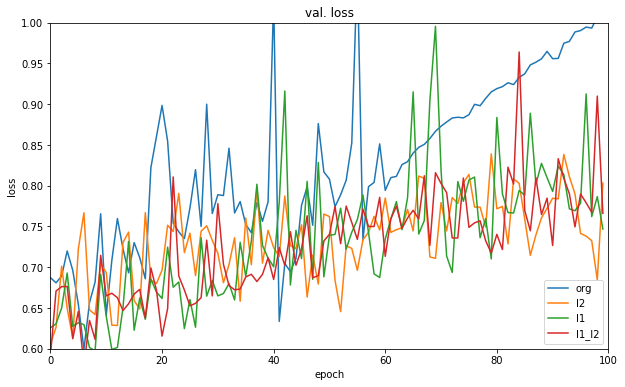

In [ ]:
type_model =['org','l2','l1','l1_l2']
loss_all = {'org':[], 'l2':[],'l1':[],'l1_l2':[]}
loss_all['org']    = history_org.history['val_loss']
loss_all['l2']    = history_l2.history['val_loss']
loss_all['l1']    = history_l1.history['val_loss']
loss_all['l1_l2'] = history_l1_l2.history['val_loss']

plt.figure(figsize=(10, 6))
plt.axis((0,NUM_EPOCHS,0.6,1))
for typem in type_model:
  plt.plot(loss_all[typem])

plt.title('val. loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(type_model, loc='lower right')
plt.show()

**Do exemplo anterior podemos observar que**:
* Os modelos regularizados são mais resistente ao _overfitting_ que o modelo original, embora ambos os modelos tenham a mesma arquitetura.


### Regularização usando _dropout_

_Dropout_ é uma das técnicas de regularização de maior eficacia e mais usada em DL.  Se você tem um modelo de alta variância, _Dropout_ é uma boa primeira escolha para reduzir o _overfitting_.

_Dropout_ faz exatamente o que diz, desliga neurônios da camada onde é aplicada, ou seja, consiste em desligar aleatoriamente (configurando para zero) vários elementos da saída da referida camada durante o treinamento. Por exemplo:
* Digamos que uma determinada camada normalmente retornaria como saída um vetor $[0,2, 0,5, 1,3, 0,8, 1,1]$ para uma determinada entrada durante o treinamento.
* Após aplicar _dropout_ sobre a camada, o vetor de saída terá alguns elementos zerados, distribuídos aleatoriamente: por exemplo, $[0, 0.5, 1.3, 0, 1.1]$. A taxa de _dropout_ é a fração dos elementos que são zerados; normalmente esta taxa esta entre $0,2$ e $0,5$.

No tempo de teste, nenhum elemento da saída é descartado. Em vez disso, os valores de saída da camada são reduzidos por um fator igual à taxa de _dropout_, para equilibrar o fato de que mais elementos estão ativos do que no tempo de treinamento.


Seja, `layer_output` uma matriz Numpy de tamanho `(batch_size, features)` que contem a saída de uma camada.
* **No tempo de treinamento**, zeramos aleatoriamente uma fração dos valores da matriz:
```python
# No tempo de treinamento, 50% dos elementos na saída são desligados
layer_output *= np.random.randint(0, high=2, size=layer_output.shape)
```
* **No tempo de teste**, escalamos a saída pelo _dropout rate _. Aqui, nós escalamos por $0,5$
(porque anteriormente baixamos a metade os elementos da saída):
```python
# No tempo de teste
layer_output *= 0.5
```
Observe que esse processo pode ser implementado executando as duas operações no momento do treinamento e deixando a saída inalterada no momento do teste, o que geralmente é o modo como é implementado na prática (ver a seguinte figura):
```python
# No tempo de treinamento
layer_output *= np.random.randint(0, high=2, size=layer_output.shape)
layer_output /= 0.5
```

**Figura**. _Dropout_ aplicado a uma matriz de ativação no momento do treinamento, com reescalonamento ocorrendo durante o treinamento. Na hora do teste, a matriz ativação é inalterada.

<img src='https://drive.google.com/uc?id=1JidTd1pDBI2sBClKgNtHKrBevu1U4dNk' width=50%>

_Dropout_ pode parecer uma técnica estranha e arbitrária. Por que isso ajudaria a reduzir o _overfitting_?
* Hinton, o criador da técnica, diz que foi inspirado, entre outras coisas, por um mecanismo de prevenção de fraude usado pelos bancos. Em suas próprias palavras,
  * **fui ao meu banco. Onde os atendentes das caixas sempre trocabam, e eu perguntei a um deles por quê. Ele disse que não sabia, mas eles trocabam muito. Achei que deveria ser porque exigiria cooperação entre todos os funcionários para fraudar com sucesso o banco. Isso me fez perceber que remover aleatoriamente um subconjunto diferente de neurônios em cada exemplo evitaria conspirações e, assim, reduziria o _overfitting_**.

A idéia central é que a introdução de ruído nos valores de saída de uma camada pode quebrar padrões de acaso que não são significativos (o que Hinton chama de conspirações), que a rede começará a memorizar se não houver ruídos.

Em Keras, você pode fazer uso de _dropout_ em uma rede através da camada _Dropout_, que é aplicada à saída da camada logo antes dela:
```python
model.add (layers.Dropout (0.5))
```

No exemplo a seguir, aplicamos a Dropout entre as camadas ocultas de uma rede. Para fazer isso, começaremos criando a função `build_network` que permite construir uma rede neural que tem como argumento de entrada um flag indicando o usso de _dropout_ ou não entres as camadas ocultas da rede, conforme mostrado no código a seguir:

In [ ]:
def build_network(flag_dropout = True,rate_dropout = 0.5):
  #PASO 2: CONSTRUINDO O MODELO
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28), name="input"))
  model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu, name="hidden1"))
  if(flag_dropout): model.add(tf.keras.layers.Dropout(rate_dropout))
  model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu, name="hidden2"))
  if(flag_dropout): model.add(tf.keras.layers.Dropout(rate_dropout))
  model.add(tf.keras.layers.Dense(10,  activation=tf.nn.softmax, name="output"))

  model.compile(optimizer = 'adam',loss='categorical_crossentropy',metrics=['accuracy'])

  return model

Agora, usando a função `build_network` construimos quatro modelos:
1. `model_org` é o modelo original, onde suas camadas ocultas não estão regularizadas.
1. `model_1` é o modelo  regularizado via camdas de _Dropout_ com taxa de _dropout_ igual a $0.5$.
1. `model_2` é o modelo  regularizado via camdas de _Dropout_ com taxa de _dropout_ igual a $0.7$.
1. `model_3` é o modelo  regularizado via camdas de _Dropout_ com taxa de _dropout_ igual a $0.9$.

In [ ]:
#modelo original
model_org = build_network(False)
#modelo com dropout = 0.5
model_1 = build_network(True,0.5)
#modelo com dropout = 0.7
model_2 = build_network(True,0.7)
#modelo com dropout = 0.9
model_3 = build_network(True,0.9)

Depois, efetuamos o passo de treinamento dos modelos criados, para cada casso, chamando ao método `fit`, conforme mostrado no código a seguir:

In [ ]:
BATCH_SIZE = 32 # number de amostras por batch
NUM_EPOCHS = 100 # numero de epocas

print('Treinando o modelo original')
history_org = model_org.fit(x_train, y_train_one_hot,
                            batch_size = BATCH_SIZE,
                            epochs = NUM_EPOCHS,
                            verbose = 0,
                            validation_data=(x_valid, y_valid_one_hot))

print('Treinando o modelo com uma taxa de dropout = 0.5')
history_1 = model_1.fit(x_train, y_train_one_hot,
                            batch_size = BATCH_SIZE,
                            epochs = NUM_EPOCHS,
                            verbose = 0,
                            validation_data=(x_valid, y_valid_one_hot))

print('Treinando o modelo com uma taxa de dropout = 0.7')
history_2 = model_2.fit(x_train, y_train_one_hot,
                            batch_size = BATCH_SIZE,
                            epochs = NUM_EPOCHS,
                            verbose = 0,
                            validation_data=(x_valid, y_valid_one_hot))

print('Treinando o modelo com uma taxa de dropout = 0.9')
history_3 = model_3.fit(x_train, y_train_one_hot,
                            batch_size = BATCH_SIZE,
                            epochs = NUM_EPOCHS,
                            verbose = 0,
                            validation_data=(x_valid, y_valid_one_hot))

Treinando o modelo original
Treinando o modelo com uma taxa de dropout = 0.5
Treinando o modelo com uma taxa de dropout = 0.7
Treinando o modelo com uma taxa de dropout = 0.9


Finalmente, plotamos a _loss_ para o conjunto validação:

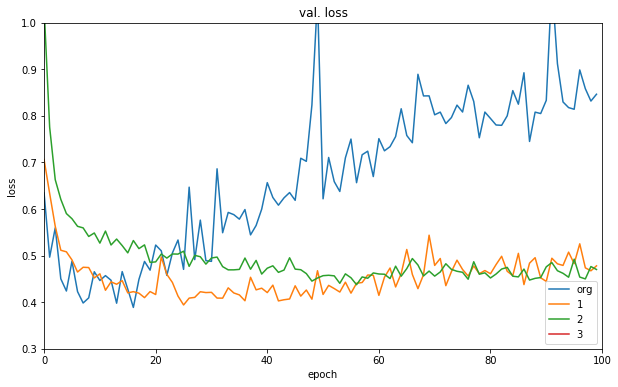

In [ ]:
type_model =['org','1','2','3']
loss_all = {'org':[], '1':[],'2':[],'3':[]}
loss_all['org'] = history_org.history['val_loss']
loss_all['1'] = history_1.history['val_loss']
loss_all['2'] = history_2.history['val_loss']
loss_all['3'] = history_3.history['val_loss']

plt.figure(figsize=(10, 6))
plt.axis((0,NUM_EPOCHS,0.3,1))
for typem in type_model:
  plt.plot(loss_all[typem])

plt.title('val. loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(type_model, loc='lower right')
plt.show()

**Do exemplo anterior podemos observar que**:
* Os modelos regularizados são mais resistente ao _overfitting_ que o modelo original, embora ambos os modelos tenham a mesma arquitetura. Você pode ver o impacto que o _dropout_ teve no overfitting do modelo é realmente bastante pronunciado. Embora isso se traduza apenas em uma melhoria marginal no produto final, o _dropout_ está fazendo um bom trabalho ao evitar que a loss da validação suba.


### Recapitulando

As formas mais comuns de evitar o _overfitting_ em redes neurais são:
* Obtenha mais dados de treinamento.
* Reduzir a capacidade da rede.
* Adicionar regularização via a norma L1 ou L2.
* Adicionar _dropout_.

## O fluxo de trabalho universal de ML

Nesta seção, apresentaremos um modelo universal que você pode usar para atacar e solucionar qualquer problema de ML.

### Definindo o problema e montando um conjunto de dados

Primeiro, deve-se definir o problema em questão:
* **Quais são os dados de entrada?**  **o que se está tentando prever?**
  * Só se pode aprender a prever algum resultado se existirem dados de treinamento disponíveis. Por exemplo,
    * queremos aprender a classificar se a resenha de um filme é positiva ou negativa, nesse caso, precissamos de comentários anotados dos filmes (aqui, cada anotação corresponde à classificação + ou - atribuida a um comentario).
  * Como tal, a disponibilidade de dados é normalmente um fator limitante neste estágio (a menos que você tenha meios para pagar pessoas que possam coletar dados para você).

* **Que tipo de problema você está enfrentando?**
  * Identificar o tipo de problema guiará sua escolha na: arquitetura do modelo, função de perda e assim por diante. Entre os tipos de problemas de ML temos:
    * Classificação binária.
    * Classificação multiclasse.
    * Regressão escalar.
    * Regressão vetorial.
    * Classificação multilabel
    * _Clustering_.
    * Aprendizado de reforço, etc.

não deve-se passar para o próximo estágio até saber quais são as entradas e saídas e que dados serão usados. Sempre lembre das hipóteses feitas neste estágio:
* As saídas esperadas podem ser previstas de acordo com as entradas observadas;
* os dados disponíveis são suficientemente informativos para aprender a relação entre as entradas observadas e as saídas esperadas.

Até que você tenha um modelo de trabalho, estas são meras hipóteses, esperando para serem validadas ou invalidadas.
Nem todos os problemas podem ser resolvidos; só porque você montou exemplos de entradas $x$ e saídas esperadas $y$ não significa que $x$ contém informações suficientes para prever $y$. Por exemplo,
* se você está tentando prever os movimentos de uma ação no mercado de ações devido a seu histórico de preços recente, é improvável que você tenha sucesso, **porque o histórico de preços não contém muita informação preditiva**.

**Uma classe de problemas insolúveis dos quais temos que estar cientes é de problemas não estacionários**. Por exemplo:
* Suponha que você esta tentando criar um mecanismo de recomendação para roupas, e estas treinando um modelo de ML usando um mês de dados (agosto) para ser testado na recomendação de compra de roupas no inverno.
  * Um grande problema é que os tipos de roupas que as pessoas compram mudam em relação à estação do ano, a compra de roupas é um fenômeno não-estacionário na escala de alguns meses.
  * O que você está tentando modelar são as alterações ao longo do tempo. Nesse caso, a forma de trabalho correta é:
    * reciclar seu modelo constantemente usando dados do passado recente ou
    * reunir dados em uma escala de tempo em que o problema possa ser considerado estacionário.
* Para um problema cíclico, como a compra de roupas, alguns dados são suficientes para captar a variação sazonal - mas lembre-se de fazer da época do ano uma entrada do seu modelo!
___
**Tenha em mente que ML só pode ser usado para memorizar padrões que estão presentes em seus dados de treinamento**. Você só pode reconhecer o que viu antes.

**Usar um modelo de ML treinado em dados passados para prever o futuro é supor que o futuro se comportará como o passado.** Isso geralmente não é o caso.
___


### Escolhendo uma medida de sucesso

Para alcançar o sucesso, deve-se definir o que se entende por sucesso - acuracia? _Precision_ e _Recall_? Taxa de retenção de clientes?

A métrica que pondera o sucesso na solução de um problema guiará na escolha da função de perda (o que seu modelo otimizará).
* Para **problemas de classificação balanceada**, em que todas as classes são igualmente prováveis, a acuracia e a área sob a curva característica de operação do receptor (ROC AUC) são métricas comuns.

* Para **problemas com desbalanceamento de classes**, pode-se usar as métricas de _precision_ e _recall_.

* Para **problemas de classificação ou classificação _multilabel_**, pode-se usar a precisão média.

Não é incomum ter que definir uma métrica específica para medir o sucesso de um modelo ao solucionar um problema.
* Para ter uma ideia da diversidade das métricas usadas em ML e como elas se relacionam com diferentes domínios de problemas, é útil navegar nas competições de ciência de dados no Kaggle (https://kaggle.com); eles exibem uma ampla gama de problemas e métricas de avaliação.

### Decidindo sobre um protocolo de avaliação

Depois de definir o objetivo, é necessário estabelecer que protocolo de avaliação será usado, entre os mais comuns temos:

* **Mantendo um _hold-out validation set_**. - A escolha a elegir quando você tem muitos dados
* **Fazendo $K$-_fold cross-validation_** - A escolha certa quando tem-se poucas amostras para que a validação via de _hold-out validation set_ seja confiável
* **Fazendo _iterated_ $K$-_fold validation_** A escolha quando é precisso fazer uma avaliação do modelo altamente precisa contando com poucos dados.

### Preparando os dados

Depois de definr o conjunto de dados de treinamento,escolher uma medida de sucesso e definr o protocolo de avaliação,  se está quase pronto para começar a treinar  o modelo. Mas, primeiro, deve-se formatar os dados de uma forma que possa ser inserida em um modelo de ML - aqui, é assumido que o modelo é uma rede neural profunda, neste caso:
* Os dados devem ser formatados como tensores.
* Os valores contidos nesses tensores geralmente devem ser redimensionados para valores pequenos: por exemplo, na faixa de $[-1, 1]$ ou de $[0, 1]$.
* Se diferentes características apresentam valores em faixas diferentes (dados heterogêneos), os dados deverão ser normalizados.
* Você pode querer fazer usso de _feature engineering_, especialmente para problemas com conjuntos de dados pequenos.

Quando os tensores dos dados de entrada e dos dados de saída estiverem prontos, pode-se iniciar o treinamento do modelo.

### Desenvolvendo um modelo que faz um melhor trabalho que o _baseline_

O objetivo neste estágio é obter **poder estatístico**, isto é:
* Desenvolver um modelo pequeno capaz de vencer uma linha de base (_baseline_) simples.
  * No exemplo de classificação dos dígitos MNIST, qualquer modelo que obtenha uma acuracia maior a $10\%$ pode ser considerado como tendo poder estatístico.

Aqui é importante indicar que nem sempre é possível obter poder estatístico.
Se NÃO se consegue superar uma linha de base aleatória depois de tentar várias arquiteturas razoáveis, pode ser que a resposta à pergunta que se está fazendo não esta presente nos dados de entrada. É necessario Lembrar que você duas hipóteses foram feitas:
* As saídas esperadas podem ser previstas de acordo com as entradas observadas;
* os dados disponíveis são suficientemente informativos para aprender a relação entre as entradas observadas e as saídas esperadas.

Pode ser que essas hipóteses sejam falsas e, nesse caso, deve-se voltar à repensar a solução proposta.

Supondo que as coisas estão bem, é preciso fazer três escolhas chaves para construir seu primeiro modelo:

* **Função de ativação da última camada**: isso estabelece restrições úteis na saída da rede. Por exemplo, para a classificação dos dígitos MNIST é usada a função de ativação `sofmax` na última camada; No exemplo de regressão não é usada uma função de ativação na última camada; e assim por diante.

* **Função de perda**: Deve corresponder ao tipo de problema que se está tentando resolver. Por exemplo, para problemas de classificação binária normalmente é usada a função de perda `binary_crossentropy`.

* **Configuração da etapa de otimização** - qual é o otimizador a usar? Qual é a taxa de aprendizado selecionada? Na maioria dos casos, é seguro usar o `rmsprop` com sua taxa de aprendizado padrão.

**Em relação à escolha de uma função de perda, observe que nem sempre é possível otimizar diretamente a métrica que mede o sucesso de um problema**.
  * Às vezes não há maneira fácil de transformar uma métrica em uma função de perda;
  * funções de perda, afinal,
    * precisam ser computáveis, dado apenas um mini-bacth de dados (idealmente, uma função de perda deve ser computável para um único ponto de dados) e
    * devem ser diferenciáveis (caso contrário, não é possível usar _backpropagation_ para treinar a rede).
 * Por exemplo, a métrica de classificação ROC AUC amplamente utilizada não pode ser otimizada diretamente. Assim, em tarefas de classificação, é comum otimizar para uma métrica proxy de ROC AUC, como _crossentropy_.
        * Em geral, você pode esperar que quanto menor a _crossentropy_, mais alta será a ROC AUC.

A Seguinte Tabela ajuda na escolha da função de ativação na última camada e a função de perda para alguns dos problemas típicos de ML.

| Tipo de problema | Função de ativação da ultima camada | função de perda |
| --- | --- | --- |
| _Binary classification_ | `sigmoid` | `binary_crossentropy` |
| _Multiclass, single-label classification_ | `softmax` | `categorical_crossentropy` |
| _Multiclass, multilabel classification_ | `sigmoid` | `binary_crossentropy` |
| _Regression to arbitrary values_ | `None` | `mse` |
| _Regression to values between 0 and 1_ | `sigmoid`  | `mse or binary_crossentropy` |

### Expandindo: desenvolvendo um modelo que gere _overfitting_

Depois de obter um modelo com poder estatístico, a questão é:
* o modelo desenvolvido é suficientemente poderoso? Tem camadas e parâmetros suficientes para modelar adequadamente o problema?
  * Por exemplo, uma rede com uma única camada oculta com dois neuronios teria poder estatístico no MNIST, mas não seria suficiente para resolver o problema com alta acuracia.

Deve-se lembrar do _tradeoff_ entre otimização e generalização em ML;
* o modelo ideal é aquele que fica bem na **fronteira**:
  * entre _underfitting_ e _overfitting_;
  * entre subcapacidade e sobrecapacidade.
* **Para descobrir onde se encontra essa fronteira, primeiro ela deve ser cruzada**.

Para descobrir o tamanho do modelo que é necessario, deve-se desenvolver um modelo que tenha _overfitting_. O qual é bastante fácil de conseguir:
1. Adicionando camadas.
1. Fazendo as camadas maiores.
1. Treinando para mais épocas.

Sempre monitore a perda de treinamento e a perda de validação, bem como os valores de treinamento e validação para quaisquer métricas que sejam importantes para o problema.

**Quando observe que o desempenho do modelo nos dados de validação começa a se degradar, é sinonimo de estar em _overfitting_.**

Então, a próxima etapa é começar a regularizar e afinar o modelo, para chegar o mais próximo possível do modelo ideal.

### Regularizando seu modelo e ajustando seus hiperparâmetros

Esta etapa consumirá o máximo de tempo no desenvolvimento do modelo, aqui:
o modelo será modificado repetidamente, treinando e avaliando o modelo nos conjuntos de treino e validação respectivamente (neste momento, é prohibido usar os dados do conjunto de teste).

Estas são algumas das coisas recomendaveis a ser feitas:
* Adicionar o _dropout_.
* Experimentar diferentes arquiteturas: adicionando ou removendo camadas.
* Adicionar regularização L1 ou L2.
* Tentar diferentes valores para os hiperparâmetros (como o número de unidades por camada ou o taxa de aprendizado do otimizador) para encontrar a configuração ideal.
* Opcionalmente, considere aplicar _feature engineering_: para adição de _features_ que sejam informativas ou removendo _features_ que não são.

É necessario tomar em conta o seguinte:
* Toda vez que é usada informação inferida do processo de validação no ajuste do modelo, se esta vazando informações sobre o processo de validação no modelo.
  * Repetida apenas algumas vezes, isso é inócuo; mas feito sistematicamente ao longo de várias iterações, ele acabará fazendo com que o modelo se sobreponha ao processo de validação (mesmo que nenhum modelo seja diretamente treinado em qualquer um dos dados de validação).
  * Isso torna o processo de avaliação menos confiável.

Depois de desenvolver uma configuração do modelo que seja satisfatória, deve ser feito:
1. O modelo pode ser treinado usando todos os dados disponíveis (**treinamento e validação**).
1. O modelo deve ser avaliado no conjunto de teste.
  * Se o desempenho no conjunto de teste for significativamente pior que o desempenho no conjunto de validação, isso pode significar que o procedimento de validação não era confiável, ou que se começou a ajustar demais o modelo aos dados de validação. Nesse caso, convém alternar para um protocolo de avaliação mais confiável (como _iterated K-fold validation_).


### Recapitulando

* Defina o problema em questão e os dados sobre os quais você treinará. Colete esses dados ou anote-os com rótulos, se necessário.

* Escolha como você medirá o sucesso do seu problema. Quais métricas você monitorará nos seus dados de validação?

* Determine seu protocolo de avaliação: _hold-out validation_? _K-fold validation_? Qual parte dos dados você deve usar para validação?

* Desenvolva um primeiro modelo que faça melhor do que uma _baseline_ básico: um modelo com poder estatístico.

* Desenvolva um modelo que tenha _overfitting_.

* Regularize seu modelo e ajuste seus hiperparâmetros, com base no desempenho nos dados de validação. Muitas pesquisas sobre ML tendem a se concentrar apenas nesse passo - mas mantenham o quadro geral em mente.

# PROBLEMAS

## Problema 1

Construir um classificador multiclasse para as classes representadas pelas imagens {*T-shirt/top*}, {*Trouser*}, {*Pullover*}, {*Dress*}, {*Coat*}, {*Sandal*}, {*Shirt*}, {*Sneaker*}, {*Bag*}, {*Ankle boot*} do banco de dados Fashion MNIST. Nesse sentido, deve-se:

1. Criar um conjunto de imagens de treino, validação e teste representadas pelas imagens de {*T-shirt/top*}, {*Trouser*}, {*Pullover*}, {*Dress*}, {*Coat*}, {*Sandal*}, {*Shirt*}, {*Sneaker*}, {*Bag*}, {*Ankle boot*}  presentes no Fashion MNIST. A proporção dos conjuntos de treino e teste deve ser os valores por default (60000 imagens para treino e 10000 imagens para teste), mas o conjunto de treino deve ser subdivido em $90\%$ para treino e $10\%$ para validação.

1. Criar 2 classificadores multiclasse baseados em MLP. Tais classificadores devem ter as seguintes arquiteturas:

|||   **Primeira arquitetura de MLP**  ||
| --- | --- | --- | --- |
| Camada | Tipo de Camada | Número de neuronios | função de ativação |
| INPUT | *Full Conneted* | 200 | softmax |
| HIDDEN | *Full Conneted* | 100 | softmax |
| HIDDEN | *Full Conneted* | 60 | softmax |
| HIDDEN | *Full Conneted* | 30 | softmax |
| OUTPUT | *Full Conneted* | 10 | softmax |

|||   **Segunda arquitetura de MLP**  ||
| --- | --- | --- | --- |
| Camada | Tipo de Camada| Número de neuronios | função de ativação |
| INPUT |*Full Conneted*| 200 | relu |
| HIDDEN |*Full Conneted*| 100 | relu |
| HIDDEN |*Full Conneted*| 60 | relu |
| HIDDEN |*Full Conneted*| 30 | relu |
| OUTPUT |*Full Conneted*| 10 | softmax |

 **OBS**.
 * Para os 2 classficadores os labels devem ser codificados via *one hot encoding*.
 * O classificador MLP requerem que as imagens de entrada sejam vetorizadas e normalizadas entre $0$ e $1$.

1. Com o conjunto de treino, determinar os parâmetros de cada classificador. Onde, os hiperparâmetros a usar para o GSD devem ser:
  *  `optimizer` = definido pelo usuario;
  * `batch_size` = definido pelo usuario;
  *  `Epoch` = definido pelo usuario.

1. Com o conjunto de validação, plotar para cada classificador:
        * epoca Vs. valor medio da função de custo sobre o conjunto de validação.
        * epoca Vs. valor medio da acuracia sobre o conjunto de validação.

1. Com o conjunto de teste, determinar para cada classificador:
  * a matriz de confusão;
 * as métricas de:
    * **taxa de erro** ($terr$);
    * **acurácia** ($Ac$)
    * **acurácia para cada classe** ($Ac_{\{T - shirt/top\}}, Ac_{\{Trouser\}}, \cdots, Ac_{\{Ankle boot\}}$).
  * Dos resultados obtidos que pode concluir em relação ao desempenho do classificador multiclasse.

## SOLUÇÃO

### Primeira Rede

In [ ]:
#@title Hyperparameters { run: "auto" }

optimizer = 'Nadam' #@param ['RMSprop','Adam','Nadam','SGD','SGD + Nesterov','SGD + Momentum','SGD + Nesterov + Momentum']
batch_size = 32 #@param {type:"integer"}
epooch = 100 #@param {type:"integer"}
learning_rate = 0.05 #@param {type:"number"}

In [ ]:
#inserir tua solução para a primeira arquitetura

#-------------------------------------------------------------------------------
# Passo 1. Carregando o conjunto de dados
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Passo 2. Construindo o modelo
#-------------------------------------------------------------------------------
# Passo 2.1. Configurando as camadas
# Passo 2.2. Compilando o modelo

#-------------------------------------------------------------------------------
# Passo 3. Treinando o modelo
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Passo 4. Fazendo predições sobre o modelo
#-------------------------------------------------------------------------------

### Segunda Rede

In [ ]:
#@title Hyperparameters { run: "auto" }

optimizer = 'Nadam' #@param ['RMSprop','Adam','Nadam','SGD','SGD + Nesterov','SGD + Momentum','SGD + Nesterov + Momentum']
batch_size = 32 #@param {type:"integer"}
epooch = 100 #@param {type:"integer"}
learning_rate = 0.05 #@param {type:"number"}

In [ ]:
#inserir tua solução para a segunda arquitetura

#-------------------------------------------------------------------------------
# Passo 1. Carregando o conjunto de dados
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Passo 2. Construindo o modelo
#-------------------------------------------------------------------------------
# Passo 2.1. Configurando as camadas
# Passo 2.2. Compilando o modelo

#-------------------------------------------------------------------------------
# Passo 3. Treinando o modelo
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Passo 4. Fazendo predições sobre o modelo
#-------------------------------------------------------------------------------

## Problema 2

Para o problema de regressão baseado no DB *Boston Housing Price*. Usando $K$-*fold cross validation* determinar:
1. O número de neurônios otimo para a camada oculta da rede MLP (aqui é suposto que a arquitetura da rede MLP tem unicamente uma camada oculta).
1. O número de camadas ocultas otima para a rede MLP (aqui é suposto que a arquitetura da rede MLP contem mas de uma camada oculta, mas todas elas tem o mesmo número de neurônios).

**OBS**. Para a solução de ambos problemas é necessario criar uma função similar a `build_model` onde:
1. para o primeiro caso: tem como argumentos de entrada:
  * o número de entradas,
  * o número de neurônios na camada oculta e
  * os hiperparamêtros para a compilação do modelo.
1. para o segundo caso: tem como argumentos de entrada:
  * o número de entradas,
  * o número de camadas ocultas,
  * o número de neurônios para as camadas ocultas e
  * os hiperparamêtros para a compilação do modelo.



## SOLUÇÃO

### Conjunto de Dados

In [ ]:
boston_housing = tf.keras.datasets.boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
train_data,mean,std = normalizationFeatureWise(train_data)
test_data  -= mean
test_data  /= std

n_partition = 4
data_folds = kfoldDBHousingPrice(train_data, train_targets,n_partition)

### Primeira Parte - Variando o número de neurônios

In [ ]:
#@title Hyperparameters { run: "auto" }

optimizer = 'Nadam' #@param ['RMSprop','Adam','Nadam','SGD','SGD + Nesterov','SGD + Momentum','SGD + Nesterov + Momentum']
batch_size = 32 #@param {type:"integer"}
epooch = 100 #@param {type:"integer"}
learning_rate = 0.05 #@param {type:"number"}


hyperparameters = {
'optimizer'     : optimizer,
'batch_size'    : batch_size,
'epooch'        : epooch,
'learning_rate' : learning_rate
}

In [ ]:
def build_model_neu(num_inputs,num_neu,hyperparameters):
  #inserir tua solução aqui
  return model

In [ ]:
num_neu_ini = #adicionar
num_neu_fim = #adicionar
num_neu_inc = #adicionar

num_inputs = train_data.shape[1]
for num_neu in range(num_neu_ini,num_neu_fim,num_neu_inc):
  all_mae_histories = []
  print('processing with', num_neu, '# neurons')
  for idx,data_fold_k in enumerate(data_folds):
    print('processing fold #', idx+1)
    X_train_k = data_fold_k['train/X']
    y_train_k = data_fold_k['train/y']
    X_val_k   = data_fold_k['val/X']
    y_val_k   = data_fold_k['val/y']

    #inserir tua solução aqui
    # Passo 1. Construindo o modelo
    # Passo 2. Treinando o modelo
    # Passo 3. Avaliando o modelo

#inserir tua solução aqui
# Passo 4. Selecionando o melhor modelo em função de uma métrica de avaliação


### Segunda Parte - Variando o número de camadas

In [ ]:
#@title Hyperparameters { run: "auto" }

optimizer = 'Nadam' #@param ['RMSprop','Adam','Nadam','SGD','SGD + Nesterov','SGD + Momentum','SGD + Nesterov + Momentum']
batch_size = 32 #@param {type:"integer"}
epooch = 100 #@param {type:"integer"}
learning_rate = 0.05 #@param {type:"number"}


hyperparameters = {
'optimizer'     : optimizer,
'batch_size'    : batch_size,
'epooch'        : epooch,
'learning_rate' : learning_rate
}

In [ ]:
def build_model_lay(num_inputs,num_lay,num_neu,hyperparameters):
  #inserir tua solução aqui
  return model

In [ ]:
num_layer_ini = #adicionar
num_layer_fim = #adicionar
num_layer_inc = #adicionar

num_inputs = train_data.shape[1]
for num_layer in range(num_layer_ini,num_layer_fim,num_layer_inc):
  print('processing with', num_layer, '# layers')
  for idx,data_fold_k in enumerate(data_folds):
    print('processing fold #', idx+1)
    X_train_k = data_fold_k['train/X']
    y_train_k = data_fold_k['train/y']
    X_val_k   = data_fold_k['val/X']
    y_val_k   = data_fold_k['val/y']

    #inserir tua solução aqui
    # Passo 1. Construindo o modelo
    # Passo 2. Treinando o modelo
    # Passo 3. Avaliando o modelo

#inserir tua solução aqui
# Passo 4. Selecionando o melhor modelo em função de uma métrica de avaliação